## Necessary imports

Main dependencies:

* tensorflow 1.x for neural networks
* matplotlib for visualization
* pandas for data manipulation

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import os
import plotly
import plotly.graph_objs as go
import time
import itertools
import cv2
import seaborn as sns
import warnings
import tqdm
import math

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plotly.offline.init_notebook_mode(True)

dataset_dir = './data/'
meta_info = os.path.join(dataset_dir, 'Meta.csv')
train_csv_path = os.path.join(dataset_dir, 'Train.csv')
test_csv_path = os.path.join(dataset_dir, 'Test.csv')
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']

### Load data
We should remap path because of kaggle converts folder to lowercase mode

In [2]:
train_data_color = '#0f7b8e'
test_data_color = '#630f8e'

trainDf = pd.read_csv(train_csv_path)
testDf = pd.read_csv(test_csv_path)
metaDf = pd.read_csv(meta_info)

trainDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x), trainDf['Path']))
testDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x), testDf['Path']))
metaDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x), metaDf['Path']))

trainDf.sample(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
24005,29,30,6,6,24,24,15,./data/Train/15/00015_00020_00005.png
13379,61,60,6,5,56,55,8,./data/Train/8/00008_00040_00029.png
33905,55,54,6,5,50,49,34,./data/Train/34/00034_00004_00006.png


### Discover dataset balance
The easiest way to discover dataset balance - build histogram. We consider to use [seaborn](https://seaborn.pydata.org/) library based on matplotlib for pretty data visualization.

Train and test subset of dataset have similar balance distribution. Train and test split provided by GTSRB.

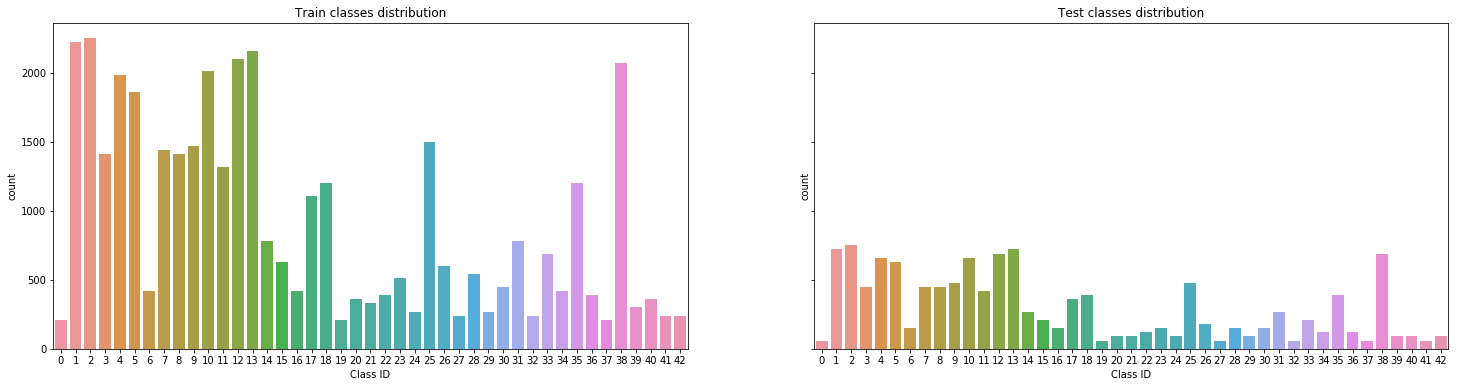

In [3]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 6))
axs[0].set_title('Train classes distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[1].set_title('Test classes distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

sns.countplot(trainDf.ClassId, ax=axs[0])
sns.countplot(testDf.ClassId, ax=axs[1])
axs[0].set_xlabel('Class ID');
axs[1].set_xlabel('Class ID');

### Image size distribution
Dataset contains thouthands of images. Images don't have the same resolution. Some of them are big, other are small. We should somehow choose appropriate resolution of samples. The best way to visualize width and height corellation - using multivariate plotting.

As we can see bellow, most of images is rectangular (it can be prooved by applying liniar regression on the samples resolution). Most of samples are about 35x35 pixels. And only few samples have big resolution like a 100x100 pixels.

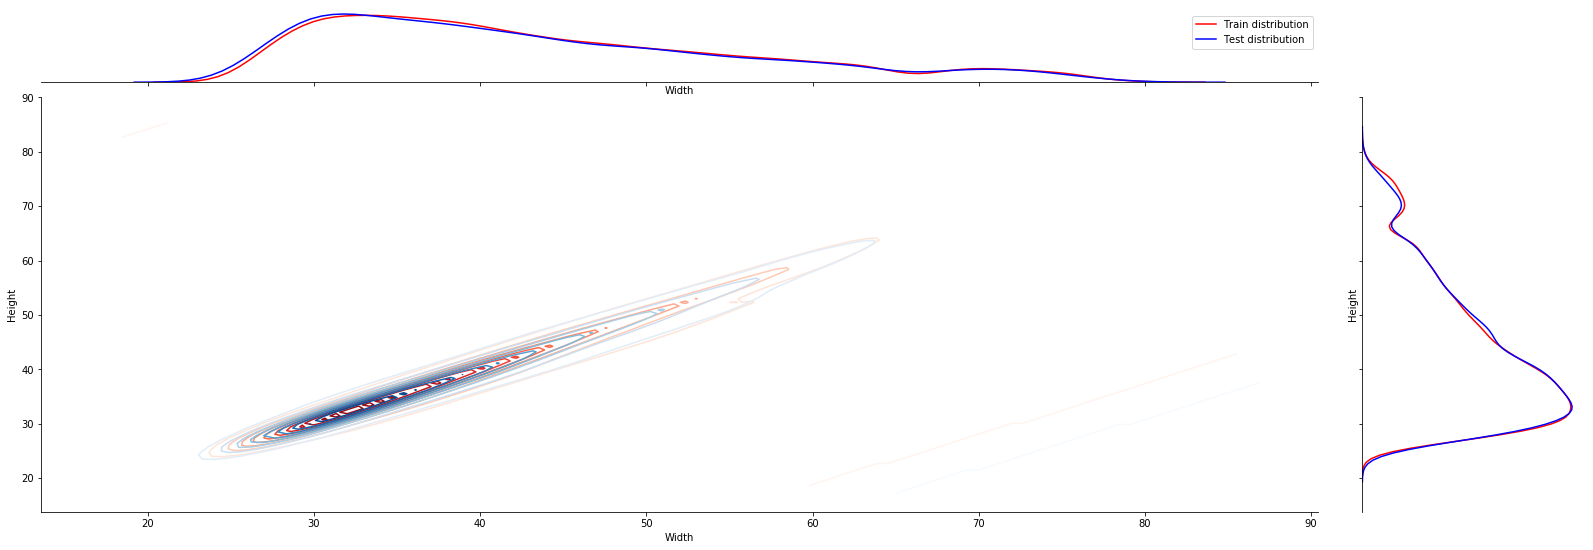

In [4]:
trainDfDpiSubset = trainDf[(trainDf.Width < 80) & (trainDf.Height < 80)];
testDfDpiSubset = testDf[(testDf.Width < 80) & (testDf.Height < 80)];

g = sns.JointGrid(x="Width", y="Height", data=trainDfDpiSubset)
sns.kdeplot(trainDfDpiSubset.Width, trainDfDpiSubset.Height, cmap="Reds",
        shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(testDfDpiSubset.Width, testDfDpiSubset.Height, cmap="Blues",
        shade=False, shade_lowest=False, ax=g.ax_joint)
sns.distplot(trainDfDpiSubset.Width, kde=True, hist=False, color="r", ax=g.ax_marg_x, label='Train distribution')
sns.distplot(testDfDpiSubset.Width, kde=True, hist=False, color="b", ax=g.ax_marg_x, label='Test distribution')
sns.distplot(trainDfDpiSubset.Width, kde=True, hist=False, color="r", ax=g.ax_marg_y, vertical=True)
sns.distplot(testDfDpiSubset.Height, kde=True, hist=False, color="b", ax=g.ax_marg_y, vertical=True)
g.fig.set_figwidth(25)
g.fig.set_figheight(8)
plt.show();

### Target class visualization
It is not a sample in the dataset, it is just a picture of sign. Some of them may be different from the dataset samples because of dataset contains images of German traffic signs and pictures bellow are Ukrainian traffic signs ([source of pictures](http://pdd.ua/33/))

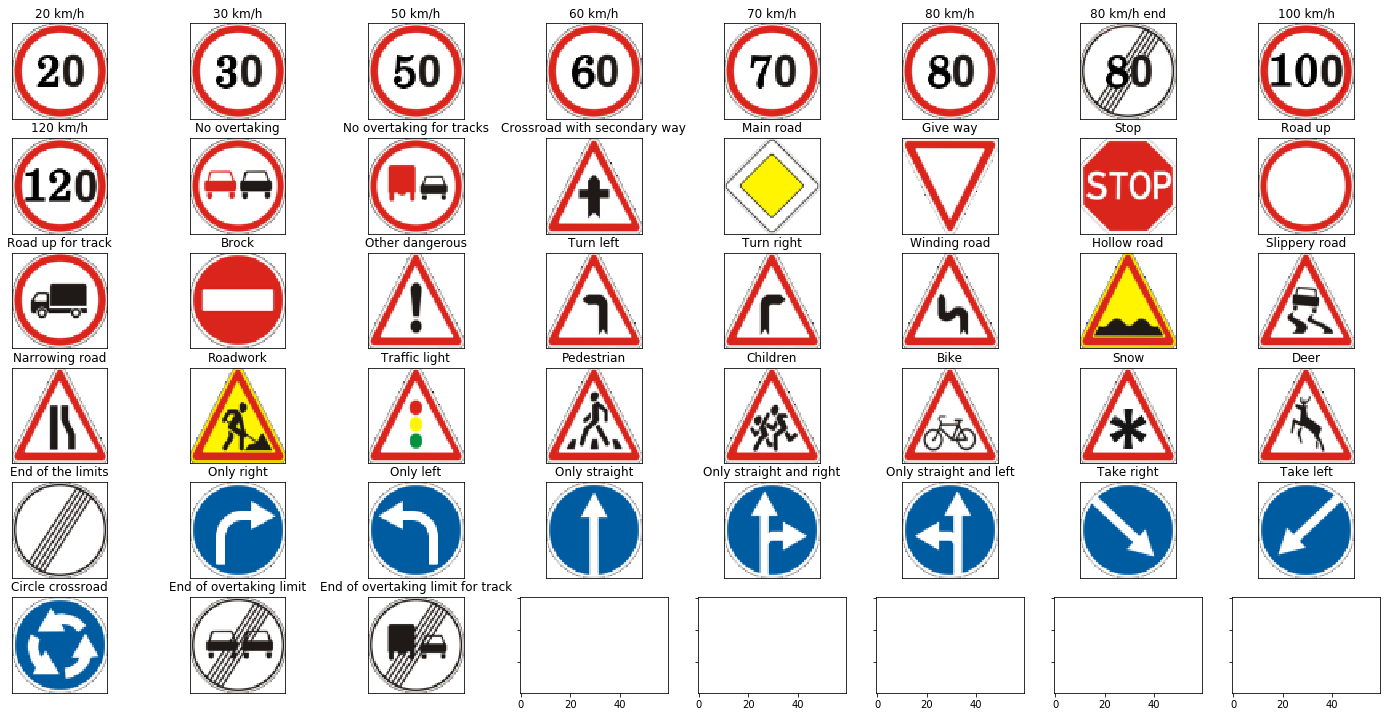

In [30]:
sns.set_style()
rows = 6
cols = 8
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
metaDf = metaDf.sort_values(by=['ClassId'])

idx = 0
for i in range(rows):
    for j in range(cols):
        if idx > 42:
            break
            
        img = cv2.imread(metaDf["Path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
        img[np.where(img[:,:,3]==0)] = [255,255,255,255]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        
        axs[i,j].imshow(img)
        axs[i,j].set_facecolor('xkcd:salmon')
        axs[i,j].set_facecolor((1.0, 0.47, 0.42))
        axs[i,j].set_title(labels[int(metaDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

### Samples visualization

It is good idea to visualize samples in order to brief data exploration. Image visualization can help to understand data problem. Some solutions (such as histogram equalization) can be discovered by visual data exploration

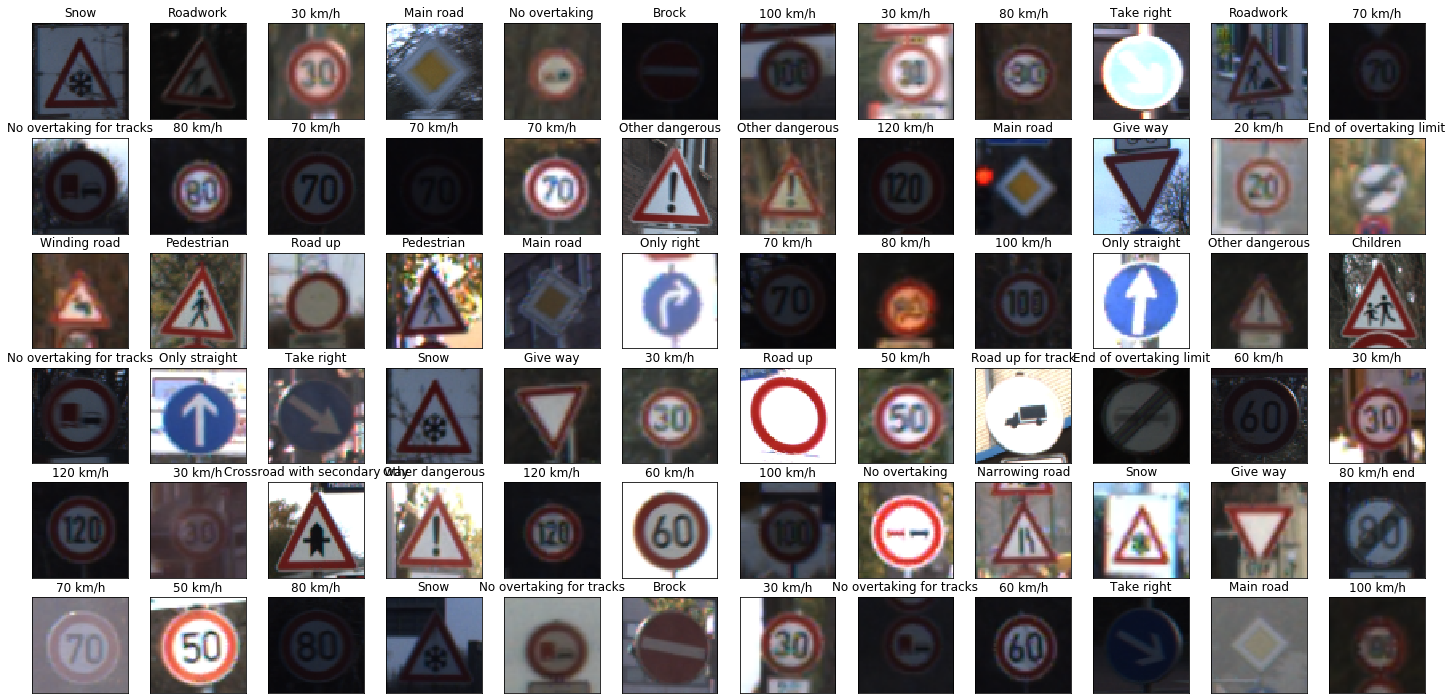

In [32]:
rows = 6
cols = 8+4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
visualize = trainDf.sample(rows*cols)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(visualize["Path"].tolist()[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        axs[i,j].imshow(img)
        axs[i,j].set_title(labels[int(visualize["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

### Tensorflow utils

We decide to use native tensorflow as deep learning framework without high level API. The best way to implement data pipleline - implement load data operation as node of comoutition graph. This will be the first node of computitional graph (i.e. all other node is depended from it). This approach has several adantages:

- Parallelism out of the box (provided by dataflow graph principies)
- Opportunity to implement data augmentation on GPU (not implemented here)
- Convenient way to wrok with it provided by tf.data infrastructure
- Fast way to use native and 3rd party python libraries wrapped by tf.py_func (deprecated since 1.13.? version)

Here we defined utils for loading tensors, augmentation and other data manipulation

In [7]:
img_load_size = (60,60)
zero_img = np.zeros([12,img_load_size[0], img_load_size[1], 3])
zero_label = np.zeros([12,1])

def parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_jpeg(image_string, channels=3)
#         image = tf.py_func(eq, [image], image.dtype)
        image.set_shape([None, None, 3])
        
        return filename, image, label
    
def train_preprocess(filename, image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_images(image, img_load_size)
    return filename, image, label

def augmentate(filename, image, label):
    return filename, image, label

def eq(img: np.ndarray):
    res = img.copy()
    res[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    res[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    res[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    
    return res

def tf_equalize_histogram(image):
    values_range = tf.constant([0., 255.], dtype = tf.float32)
    histogram = tf.histogram_fixed_width(tf.to_float(image), values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.to_float(cdf - cdf_min) * 255. / tf.to_float(pix_cnt - 1))
    px_map = tf.cast(px_map, tf.uint8)

    gth = tf.gather_nd(px_map, tf.cast(image, tf.int32))
    eq_hist = tf.expand_dims(gth, 2)
    return image

### Tensorflow data pipeline

Above we have prepared pandas DataFrame with all data. Now, let's create operaition for loading data using [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [8]:
tf.reset_default_graph()

epochs = 4
batch_size = 12
prefetch_count = 1
samples_train = len(trainDf)
samples_test = len(testDf)

dataset_train = tf.data.Dataset.from_tensor_slices((trainDf['Path'], trainDf['ClassId']))
dataset_train = dataset_train.shuffle(len(trainDf['Path']))
dataset_train = dataset_train.repeat(epochs)
dataset_train = dataset_train.map(parse_function, num_parallel_calls=4)
dataset_train = dataset_train.map(train_preprocess, num_parallel_calls=4)
dataset_train = dataset_train.map(augmentate, num_parallel_calls=4)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(prefetch_count)

dataset_iterator = tf.data.Iterator.from_structure(dataset_train.output_types,
                                                          dataset_train.output_shapes)


dataset_test = tf.data.Dataset.from_tensor_slices((testDf['Path'], testDf['ClassId']))
dataset_test = dataset_test.shuffle(len(testDf['Path']))
dataset_test = dataset_test.repeat(epochs+1)
dataset_test = dataset_test.map(parse_function, num_parallel_calls=4)
dataset_test = dataset_test.map(train_preprocess, num_parallel_calls=4)
dataset_test = dataset_test.batch(batch_size)
dataset_test = dataset_test.prefetch(prefetch_count)


train_init_op = dataset_iterator.make_initializer(dataset_train)
test_init_op = dataset_iterator.make_initializer(dataset_test)

load_filename, load_img, load_label = dataset_iterator.get_next()

Instructions for updating:
Colocations handled automatically by placer.


### Model definition

Model graph defined using native tensorflow API. Also, we should defined some placeholders in order to have opportunity to load custom controled data into netwrok (for further model analysis)

In [9]:
dp_rate = tf.placeholder(dtype=tf.float32, shape=[], name='dp_rate')

img_placeholder = tf.placeholder(shape=[None, 60,60,3], dtype=tf.float32, name='img_placeholder')
label_placeholder = tf.placeholder(shape=[None, 1], dtype=tf.int64, name='label_placeholder')
manual_load = tf.placeholder(dtype=tf.bool, shape=[], name='manual_load_placeholder')

# inp = net = tf.cond(pred=manual_load, true_fn=lambda : img_placeholder, false_fn=lambda : load_img, name='network_start')
# label = tf.cond(pred=manual_load, true_fn=lambda : label_placeholder, false_fn=lambda : load_label, name='label')

inp = net = tf.cond(manual_load, lambda: img_placeholder, lambda: load_img)
label = load_label

conv1 = net = tf.layers.conv2d(inputs=net, filters=16, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
conv2 = net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)

pool1 = net = tf.layers.max_pooling2d(inputs=net, pool_size=(2,2), strides=(2,2))

conv3 = net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
conv4 = net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)

pool2 = net = tf.layers.max_pooling2d(inputs=net, pool_size=(2,2), strides=(2,2))

conv5 = net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
conv6 = net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.conv2d(inputs=net, filters=256, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)

pool3 = net = tf.layers.average_pooling2d(inputs=net, pool_size=(2,2), strides=(2,2))

flatten1 = net = tf.layers.flatten(inputs=net)

dp1 = net = tf.layers.dropout(inputs=net, rate=dp_rate)
dense1 = net = tf.layers.dense(inputs=net, units=418)
dp1 = net = tf.layers.dropout(inputs=net, rate=dp_rate)
dense1 = net = tf.layers.dense(inputs=net, units=256)
logits = tf.layers.dense(inputs=net, units=43)

pred_classes = tf.argmax(logits, axis=1)
pred_probas = tf.nn.softmax(logits)

acc, acc_op = tf.metrics.accuracy(labels=label, predictions=pred_classes)
end_loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=label)

loss = end_loss

label_transpose = tf.transpose(label)
correct_prediction = tf.equal(pred_classes, label_transpose)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
confusion_matrix_op = tf.confusion_matrix(labels=label, predictions=pred_classes, num_classes=43)

opt = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.average_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


### Model training

Train model several epoch and store results of each epoch for further analysis

In [10]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.Session(config=config)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
# irn.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
train_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
best_acc = 0

for e in range(epochs):
    epoch_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    
    sess.run(train_init_op)
    for i in tqdm.tqdm_notebook(range(samples_train//batch_size), ascii=True, desc='Train epoch {}'.format(e)):
        _, _loss, _acc, mn = sess.run([opt, loss, accuracy, inp], feed_dict={dp_rate: 0.3, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
#         print(np.mean(mn))
        epoch_history['loss'].append(_loss)
        epoch_history['acc'].append(_acc)
        
    sess.run(test_init_op)
    for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test epoch {}'.format(e)):
        _loss, _acc = sess.run([loss, accuracy], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
        epoch_history['val_loss'].append(_loss)
        epoch_history['val_acc'].append(_acc)
        
    train_history['loss'].append(np.mean(epoch_history['loss']))
    train_history['acc'].append(np.mean(epoch_history['acc']))
    train_history['val_loss'].append(np.mean(epoch_history['val_loss']))
    train_history['val_acc'].append(np.mean(epoch_history['val_acc']))
    
    print("***EPOCH SUMMARY*** Loss: {} Acc: {} | Test Loss: {} Test Acc {}".format(train_history['loss'][-1], train_history['acc'][-1],
                                                                                    train_history['val_loss'][-1], train_history['val_acc'][-1]))

    if train_history['val_acc'][-1] > best_acc:
        best_acc = train_history['val_acc'][-1]
        save_path = saver.save(sess, "./model.ckpt")
        print("Model saved in path: %s" % save_path)


***EPOCH SUMMARY*** Loss: 0.7429273724555969 Acc: 0.8060147166252136 | Test Loss: 0.4082106351852417 Test Acc 0.9085075855255127
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.12456716597080231 Acc: 0.9685236215591431 | Test Loss: 0.2857690155506134 Test Acc 0.941143810749054
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.06053640693426132 Acc: 0.9849505424499512 | Test Loss: 0.2396526336669922 Test Acc 0.9473225474357605
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.038129772990942 Acc: 0.9903581142425537 | Test Loss: 0.3326910138130188 Test Acc 0.930766761302948


### Training result

It's good practice to visualize accuracy and loss evolution. [plotly](https://plot.ly/) library gives as way to build interactive figures inplace in jupyter

In [11]:
titlefont = dict(family='Courier New, monospace', size=18, color='#7f7f7f')
layout = go.Layout(title='Traing & Test loss', xaxis=dict(title='Epoch', titlefont=titlefont),
                                    yaxis=dict(title='Loss', titlefont=titlefont))
fig = go.Figure(data=[go.Scatter(y=train_history['loss'], name='Train loss'), go.Scatter(y=train_history['val_loss'], name='Test loss')], layout=layout)
plotly.offline.iplot(fig)

layout = go.Layout(title='Traing & Test accuracy', xaxis=dict(title='Epoch', titlefont=titlefont),
                                    yaxis=dict(title='Accuracy', titlefont=titlefont))
fig = go.Figure(data=[go.Scatter(y=train_history['acc'], name='Train accuracy'), go.Scatter(y=train_history['val_acc'], name='Test accuracy')], layout=layout)
plotly.offline.iplot(fig)

### Model performance data preparation

For futher model analysis we need some data. Very good solution - store all statistic data in pandas DataFrame data structure. Let's evaluate all test samples and store all information about prediction, probabilities and other information

In [12]:
saver.restore(sess, "./model.ckpt")
sess.run(test_init_op)
confusion_matrix = np.zeros([43,43])
test_analys = trainDf.copy()
predictions = []
probabilities = []
analys = []

for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test best model'):
    _files, _predictions, _probas, _gts, _cm = sess.run([load_filename, pred_classes, pred_probas, load_label, confusion_matrix_op], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
    confusion_matrix += _cm
    for i in range(batch_size):
        sample_info = {'image': _files[i].decode(), 'prediction': int(_predictions[i]), 'gt': int(_gts[i]), 'gt_probas': _probas[i][_gts[i]],
                       'prediction_probas': _probas[i][_predictions[i]], 'prediction_type': 'Correct' if _gts[i] == _predictions[i] else 'Wrong'}
        for cls_id, j in enumerate(_probas[i]):
            sample_info['prob_{}'.format(cls_id)] = j
        analys.append(sample_info)

analys_df = pd.DataFrame(analys)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt


### Model evaluation analys overview

We have built pandas DataFrame. Let's observe it structure

In [13]:
analys_df.sample(4)

,gt,gt_probas,image,prediction,prediction_probas,prediction_type,prob_0,prob_1,prob_10,prob_11,...,prob_39,prob_4,prob_40,prob_41,prob_42,prob_5,prob_6,prob_7,prob_8,prob_9
10921,3,0.998814,./data/Test/05845.png,3,0.998814,Correct,7.467357e-11,9.213441e-09,3.124461e-12,1.328696e-15,...,1.675627e-17,7.536935e-13,1.970805e-17,6.774088e-14,5.437999e-13,1.186241e-03,3.282798e-09,1.468484e-08,1.072572e-09,1.164679e-12
2729,5,0.989472,./data/Test/05792.png,5,0.989472,Correct,4.547717e-07,3.197929e-06,4.035838e-05,6.483811e-08,...,6.348860e-10,1.908973e-05,3.950506e-09,2.773360e-08,5.959088e-07,9.894723e-01,9.763356e-06,3.590243e-03,1.620371e-05,1.729326e-07
9988,18,0.915241,./data/Test/12175.png,18,0.915241,Correct,1.088458e-11,5.737513e-12,1.166688e-15,9.612722e-05,...,3.344157e-10,1.291816e-09,1.420434e-09,3.991405e-12,2.982383e-13,3.312246e-10,2.859400e-14,3.137313e-13,7.420396e-11,5.795833e-11
12524,14,0.999999,./data/Test/02034.png,14,0.999999,Correct,1.128824e-11,3.080031e-11,3.991904e-11,7.763774e-13,...,3.770295e-14,7.938865e-11,2.436153e-17,1.624843e-15,3.348544e-14,6.053231e-09,4.264569e-14,4.795320e-12,5.915283e-10,3.515666e-12


### Random prediction visualization

Using information computed above, we can visualize some random samples with their predictions. As we can see - it is impossible to recognize some pictures definitely by human, but network still generates correct predictions. Awesome!

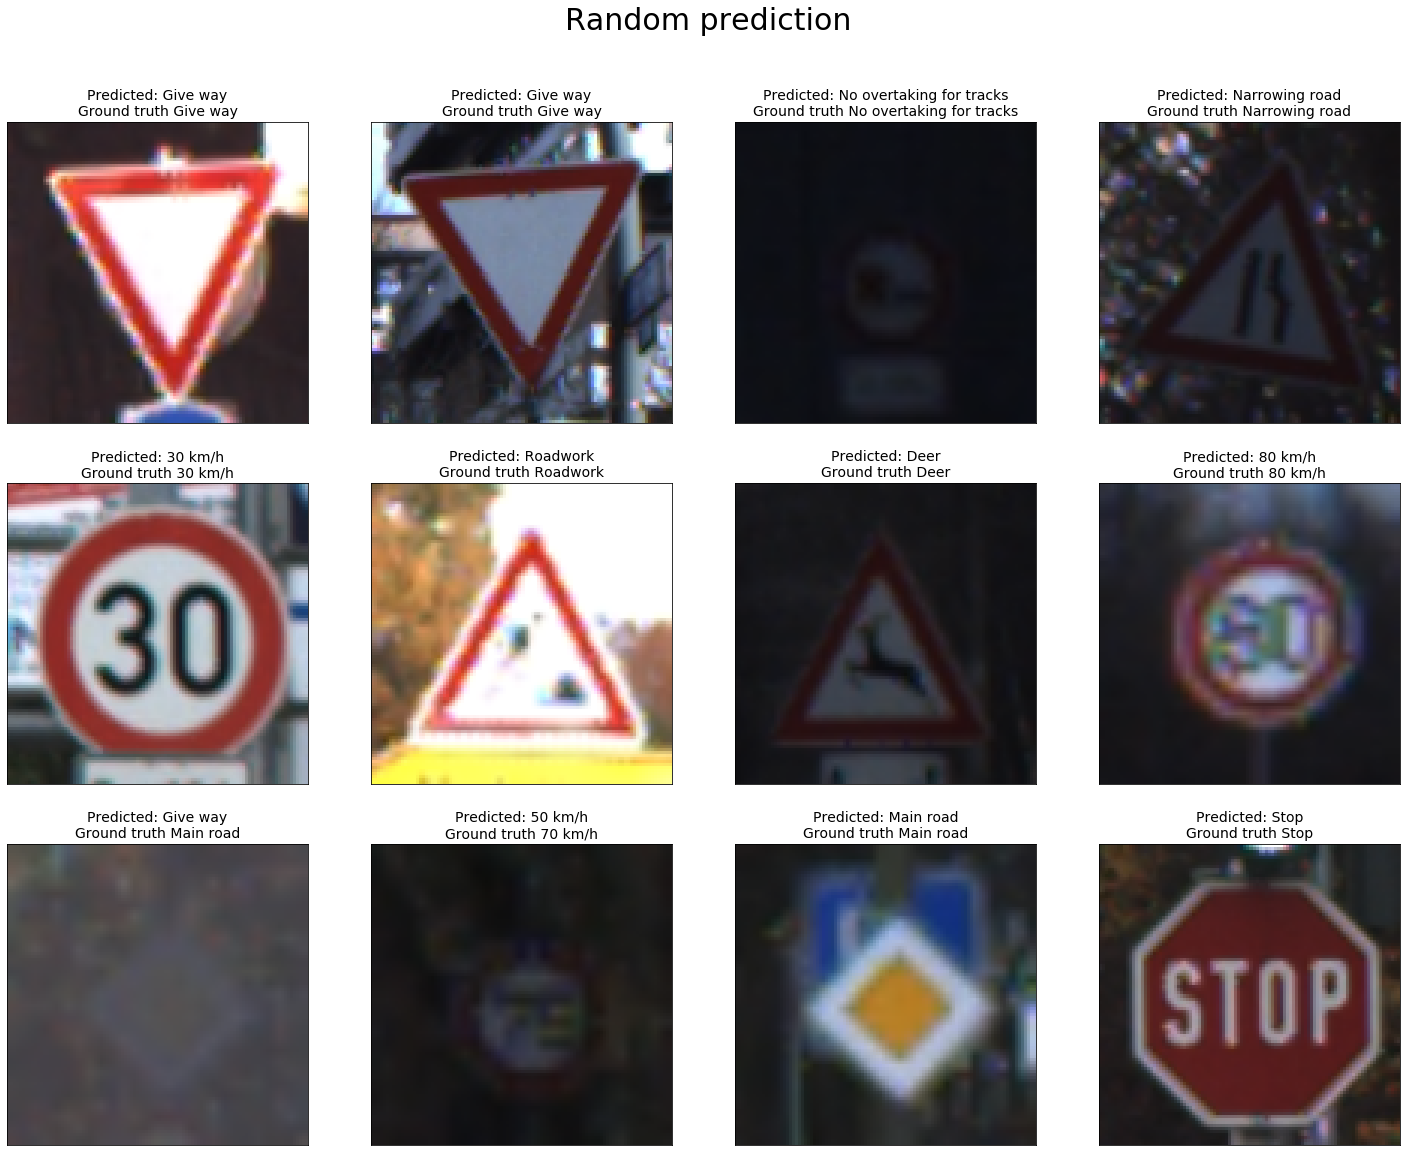

In [14]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df.copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].set_title('Predicted: {}\nGround truth {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Random prediction", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

### Wrong prediction visualization

Our model can't achieve perfect accuracy (i.e. 100%). Let's visualize wrong predicted samples. Some of them have realy bad quality, resolution. Others have unexpected artifacts (such as extreame rotation, half hidden signs or shaddow). This situations wasn't present in train part, so network have no idea how to deal with it

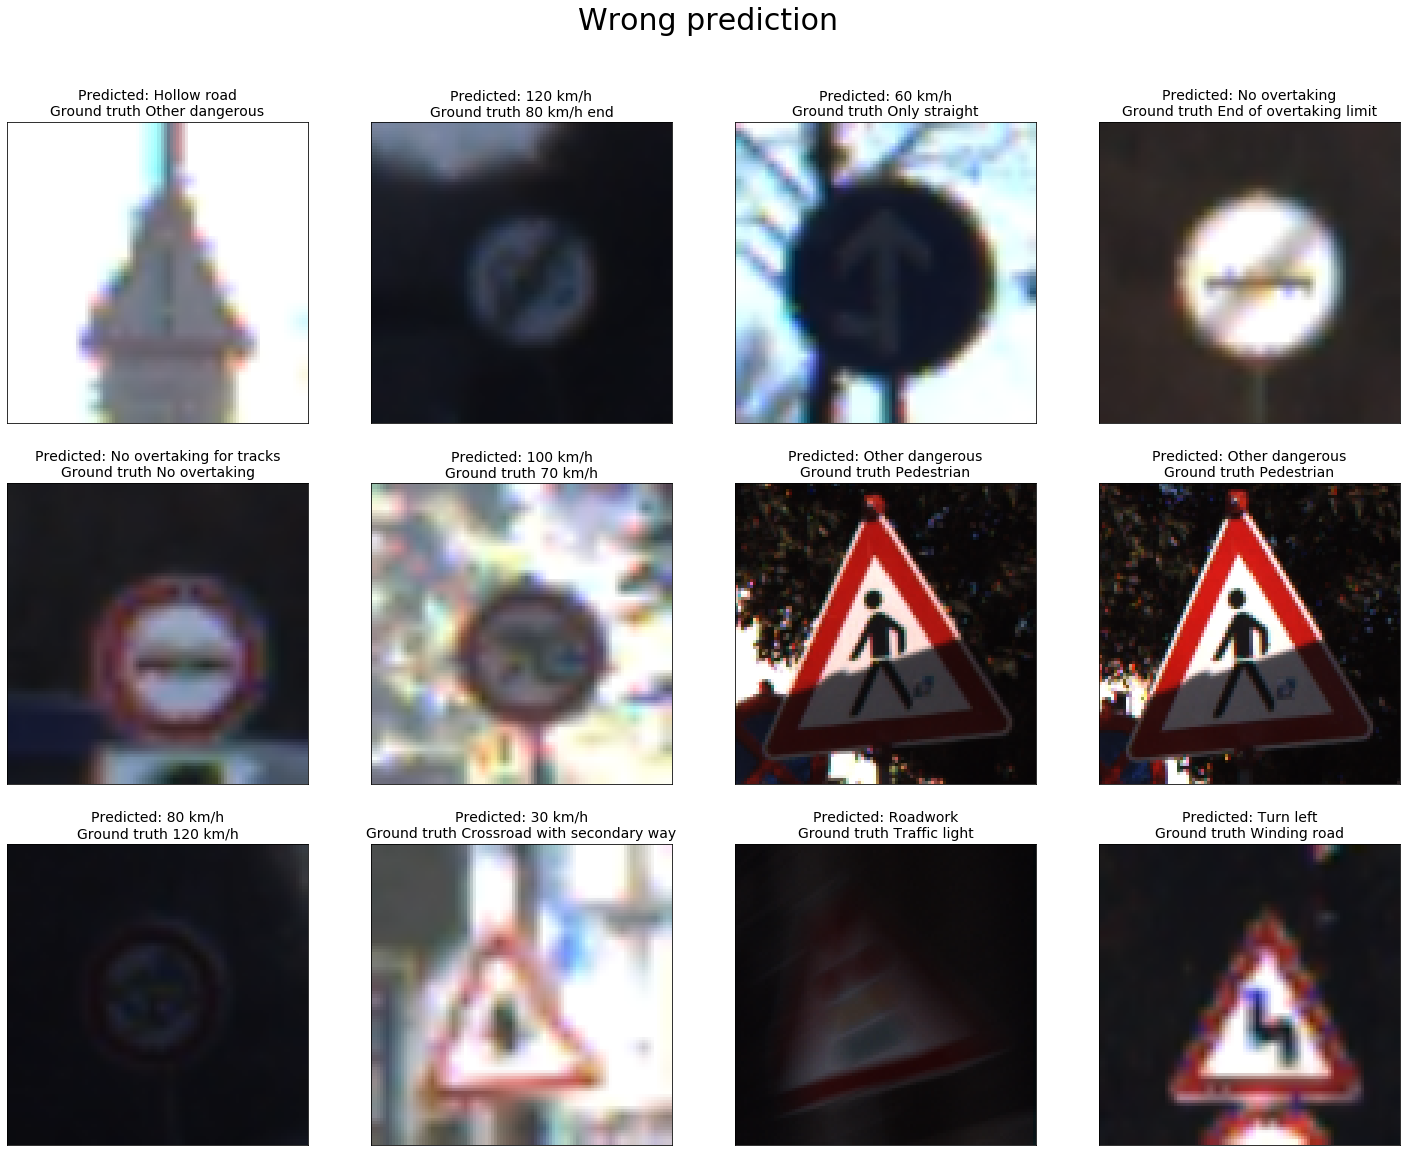

In [15]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df[analys_df['prediction_type'] == 'Wrong'].copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].set_title('Predicted: {}\nGround truth {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Wrong prediction", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, rig`ht=0.9, top=1.9, wspace=None, hspace=None)

Let's dump all wrong prediction for further analys by someone else

In [16]:
output_dir = './output'
error_dir = './output/errors'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
if not os.path.isdir(error_dir):
    os.mkdir(error_dir)

for idx, row in tqdm.tqdm_notebook(analys_df[analys_df['prediction_type'] == 'Wrong'].iterrows()):
    name = os.path.splitext(os.path.basename(row['image']))[0]
    name = '{}__{}__as__{}.png'.format(name, labels[row['gt']].replace(' ', '_'), labels[row['prediction']].replace(' ', '_'))
    img = cv2.imread(row['image'])
    cv2.imwrite(os.path.join(error_dir, name), img)

And create tar archive for convenient way to download all at once

In [17]:
!tar -cvf ./errors.tar ./output/errors 1>/dev/null

### Confusion matrix

Confusion matrix gives us additional information about accuracy distribution. It's naturally that network may be confused in prediction 'Pedestrian' and 'Other dangerous' signs. Also, confusion matrix can give us idea what to improove in network

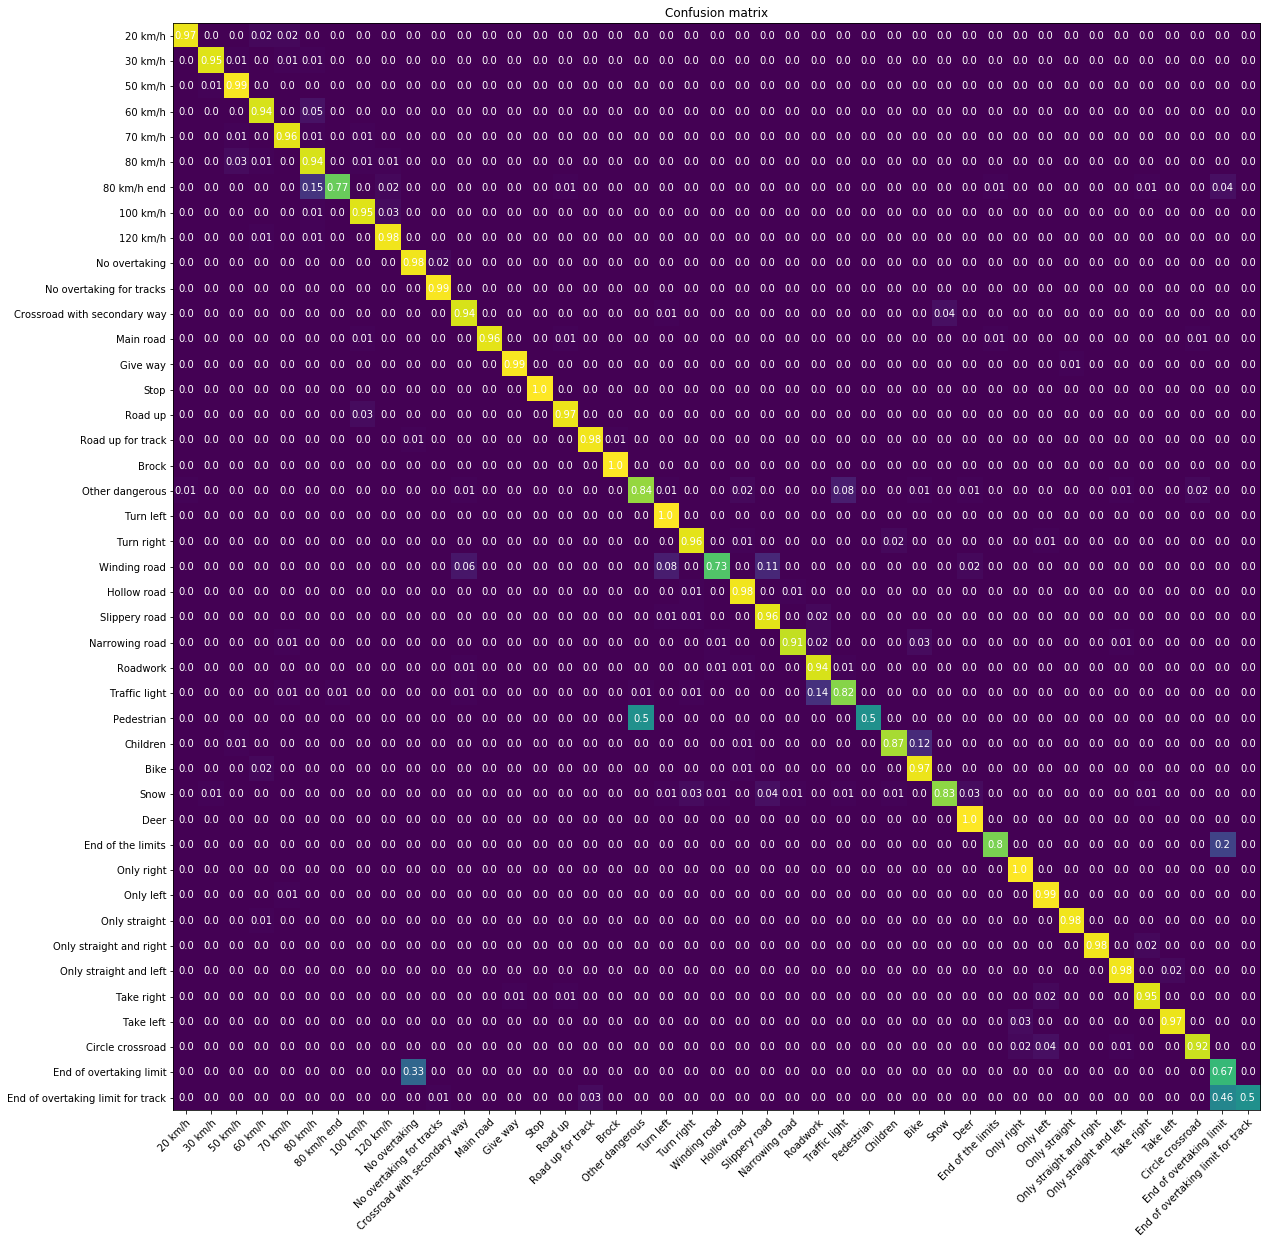

In [18]:
cm = confusion_matrix
f = np.sum(cm, axis=1)
normalized_cm = cm
for i in range(43):
    normalized_cm[i, :] /= sum(normalized_cm[i, :])

normalized_cm = np.round(normalized_cm, 2)
    
fig, ax = plt.subplots(1,1, figsize=((20, 20)))

ax.imshow(normalized_cm)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(labels)):
   for j in range(len(labels)):
       ax.text(j, i, normalized_cm[i, j], ha="center", va="center", color="w")

ax.set_title('Confusion matrix');

Here are histogram of prediction types

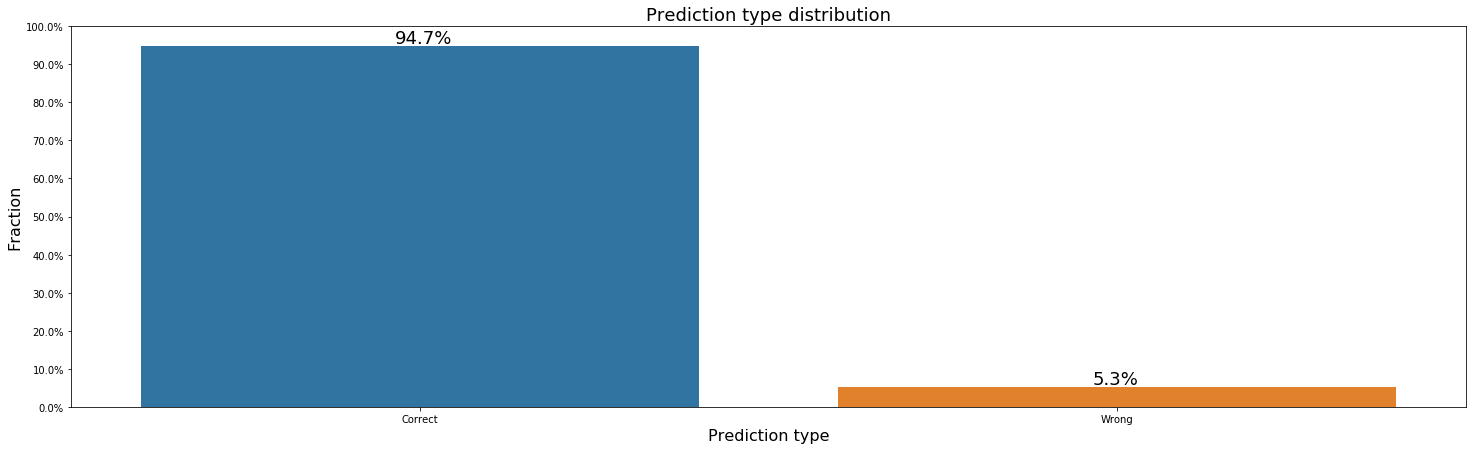

In [19]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25, 7))

px = sns.countplot(x='prediction_type', data=analys_df, ax=axs)
axs.set_title('Prediction type distribution', fontsize=18)
axs.set_xlabel('Prediction type', fontsize=16)
axs.set_ylabel('Fraction', fontsize=16);


total = analys_df.shape[0]
for idx, p in enumerate(px.patches):
        px.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.365, p.get_height()+100), fontsize=18)


px.yaxis.set_ticks(np.linspace(0, total, 11))
px.set_yticklabels(map('{:.1f}%'.format, 100*px.yaxis.get_majorticklocs()/total));

### Numerically accuracy by class
Confusion matrix produce perfect visualization for understanding why some class is so bad in predictions, but it's no so convenient way to sum up numerrically how this class is good predicted. Below are histgrams of corretly and wrong predicted classes without correlation with other classes

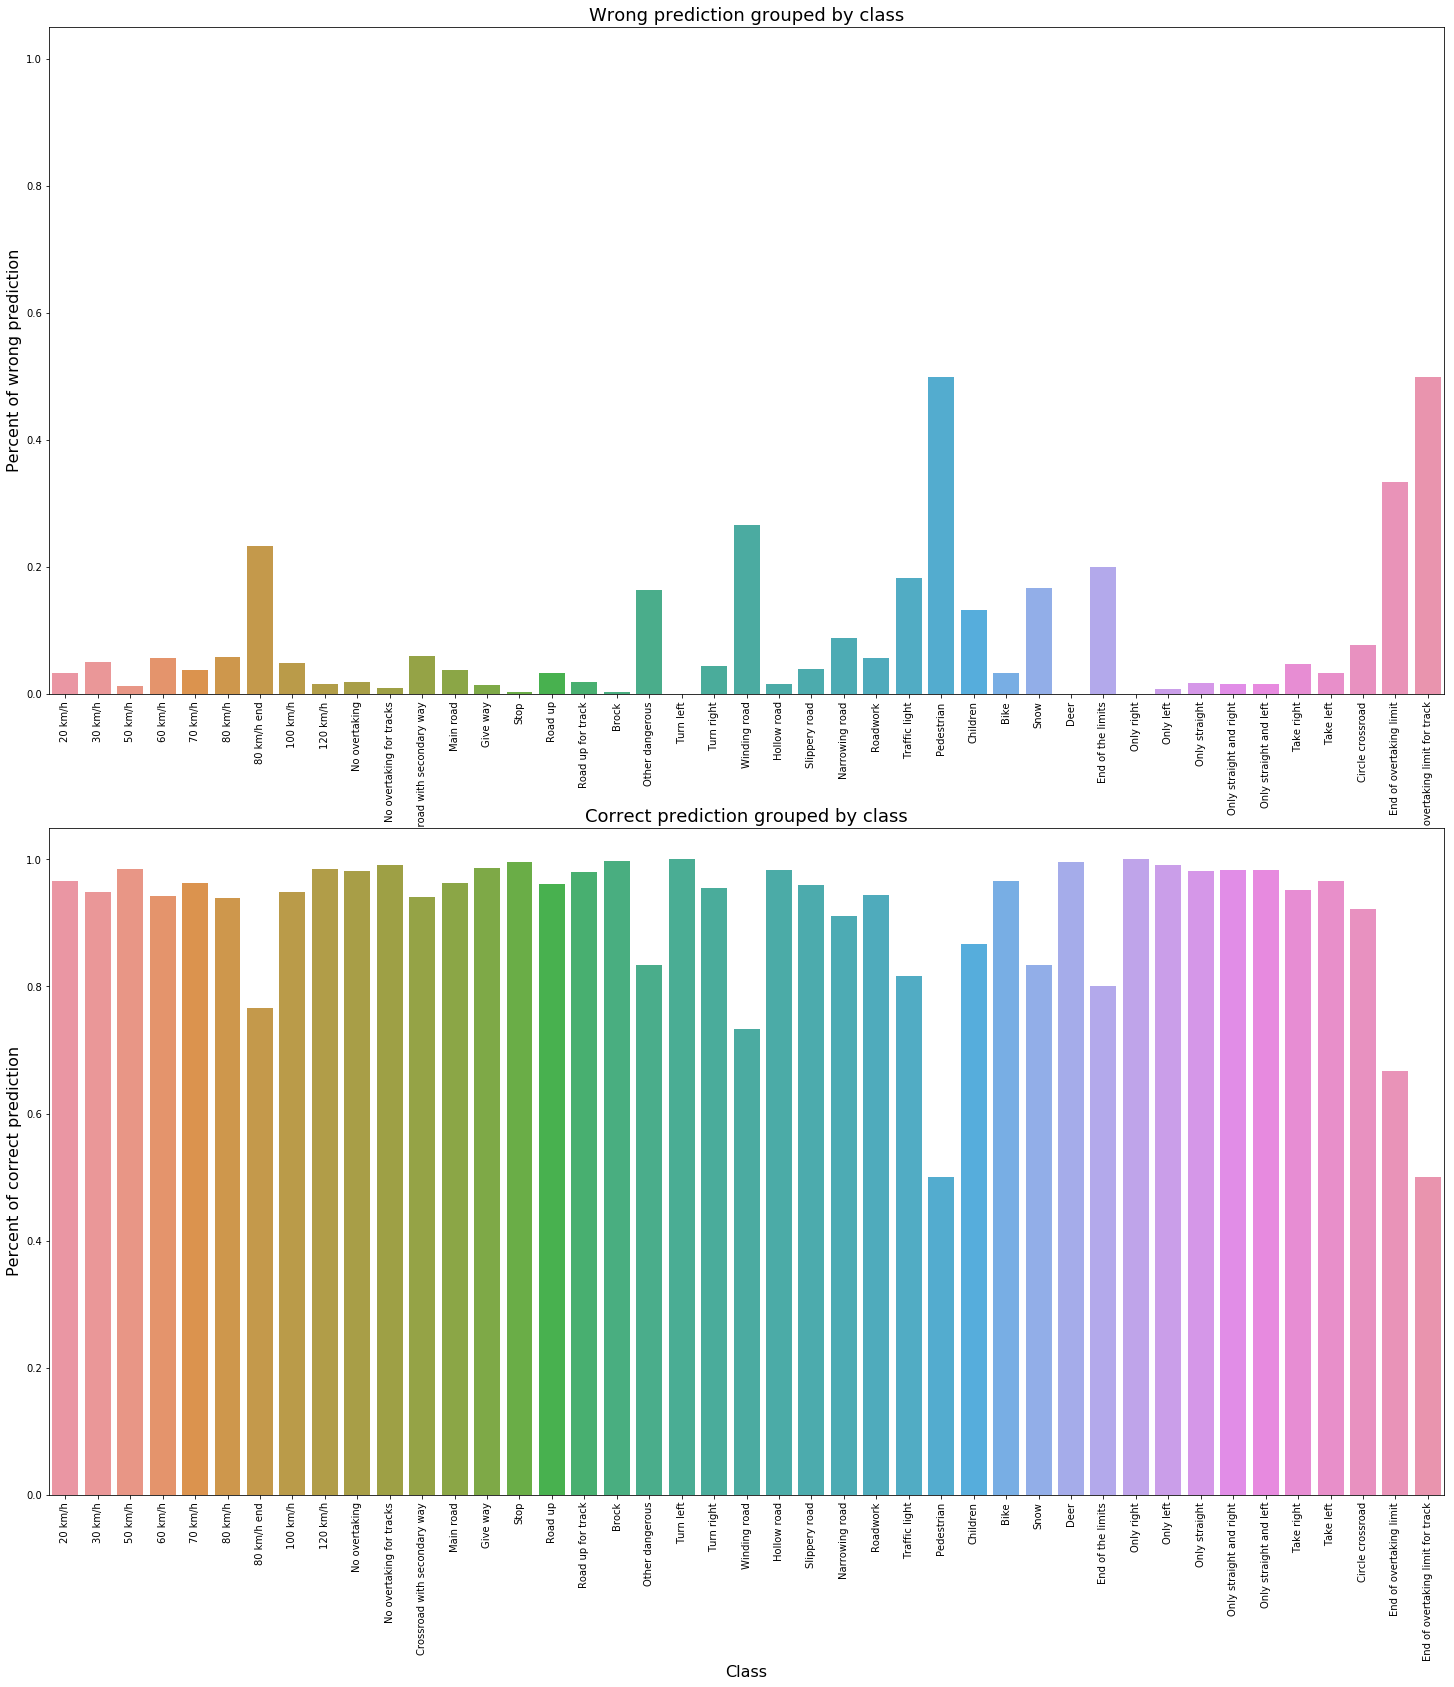

In [20]:
correct_prediction_by_class = analys_df[analys_df['prediction_type'] == 'Correct']['gt'].value_counts() / testDf['ClassId'].value_counts().sort_index()
correct_prediction_by_class_df = pd.DataFrame({'accuracy': correct_prediction_by_class, 'class': labels})

wrong_prediction_by_class = analys_df[analys_df['prediction_type'] == 'Wrong']['gt'].value_counts() / testDf['ClassId'].value_counts().sort_index()
wrong_prediction_by_class_df = pd.DataFrame({'error': wrong_prediction_by_class, 'class': labels})

fig, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(25, 27))

sns.barplot(x='class', y='accuracy', data=correct_prediction_by_class_df, ax=axs[1])
sns.barplot(x='class', y='error', data=wrong_prediction_by_class_df, ax=axs[0])

axs[0].set_title('Wrong prediction grouped by class', fontsize=18)
axs[0].set_xlabel('Class', fontsize=16)
axs[0].set_ylabel('Percent of wrong prediction', fontsize=16)
axs[0].set_xticklabels(rotation=90, labels=labels)

axs[1].set_title('Correct prediction grouped by class', fontsize=18)
axs[1].set_xlabel('Class', fontsize=16)
axs[1].set_ylabel('Percent of correct prediction', fontsize=16)
axs[1].set_xticklabels(rotation=90, labels=labels);

### Confidence analysis

Classification neural networks produce not only discrete prediction. Model is also generated probability for each class (provided by softmax layer). Can we break up with wrong prediction by analys confidence levels?

Let's build confidence level distribution

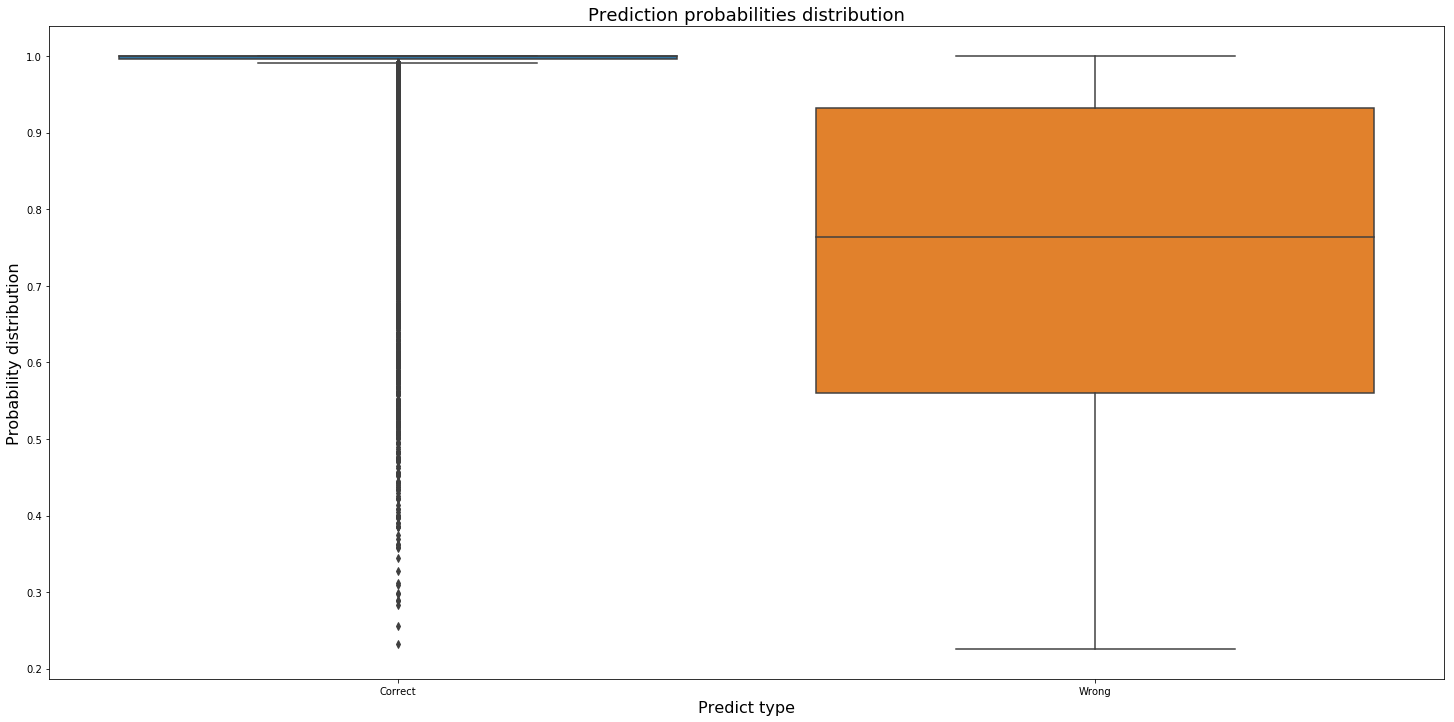

In [21]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25,12))

sns.boxplot(x='prediction_type', y='prediction_probas', data=analys_df, ax=axs);
axs.set_title('Prediction probabilities distribution', fontsize=18);
axs.set_xlabel('Predict type', fontsize=16)
axs.set_ylabel('Probability distribution', fontsize=16);

### Confidence level threshold

Find threshold for confidence level by experiment. All predictions under this threshold will be threated as 'No shure'. It is clearly, that we can't achive more accuracy that we had before, but we can reduce wrong predictions

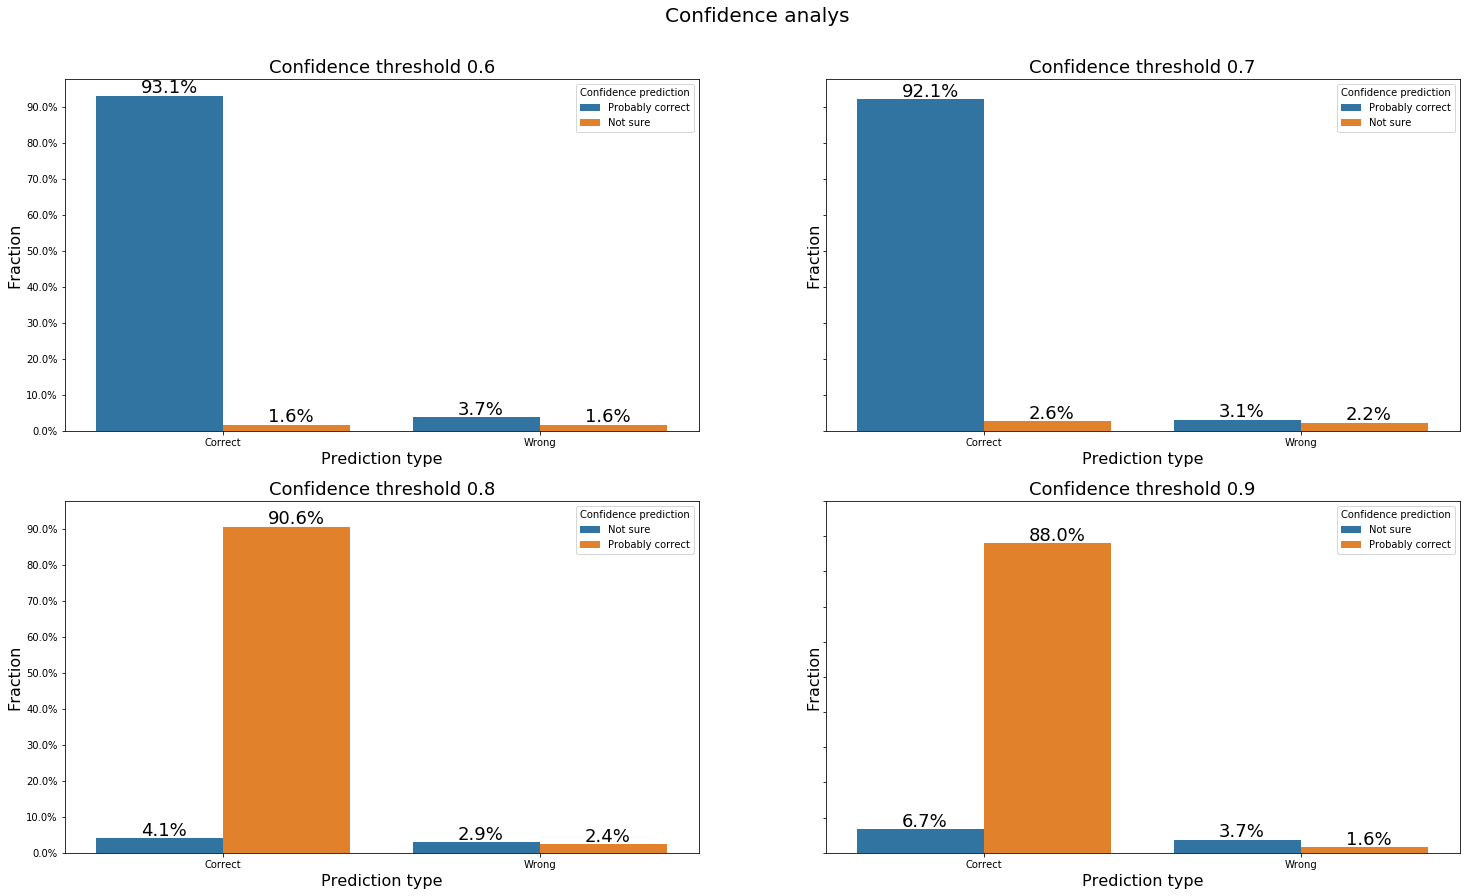

In [22]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(25,10))

confidence_thresholds = iter([0.6, 0.7, 0.8, 0.9])

for i in range(2):
    for j in range(2):
        confidence_threshold = next(confidence_thresholds)
        
        analys_df_confidence = analys_df.copy()
        new_predict = []
        for idx, row in analys_df_confidence.iterrows():
            new_predict.append('Not sure' if row['prediction_probas'] < confidence_threshold else 'Probably correct')

        analys_df_confidence['confidence_analys'] = new_predict
        
        axs = axes[i,j]
        
        px = sns.countplot(x='prediction_type', hue='confidence_analys', data=analys_df_confidence, ax=axs);
        axs.set_title('Confidence threshold {}'.format(confidence_threshold), fontsize=18)
        axs.set_xlabel('Prediction type', fontsize=16)
        axs.set_ylabel('Fraction', fontsize=16);
        axs.legend(title='Confidence prediction')

        total = analys_df_confidence.shape[0]
        for idx, p in enumerate(px.patches):
            px.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.14, p.get_height()+100), fontsize=18)


        px.yaxis.set_ticks(np.linspace(0, total, 11))
        px.set_yticklabels(map('{:.1f}%'.format, 100*px.yaxis.get_majorticklocs()/total));

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
fig.suptitle('Confidence analys', fontsize=20, y=1.3, x=0.51);

For more clearly answer, let's approximate function of confidence level threshold

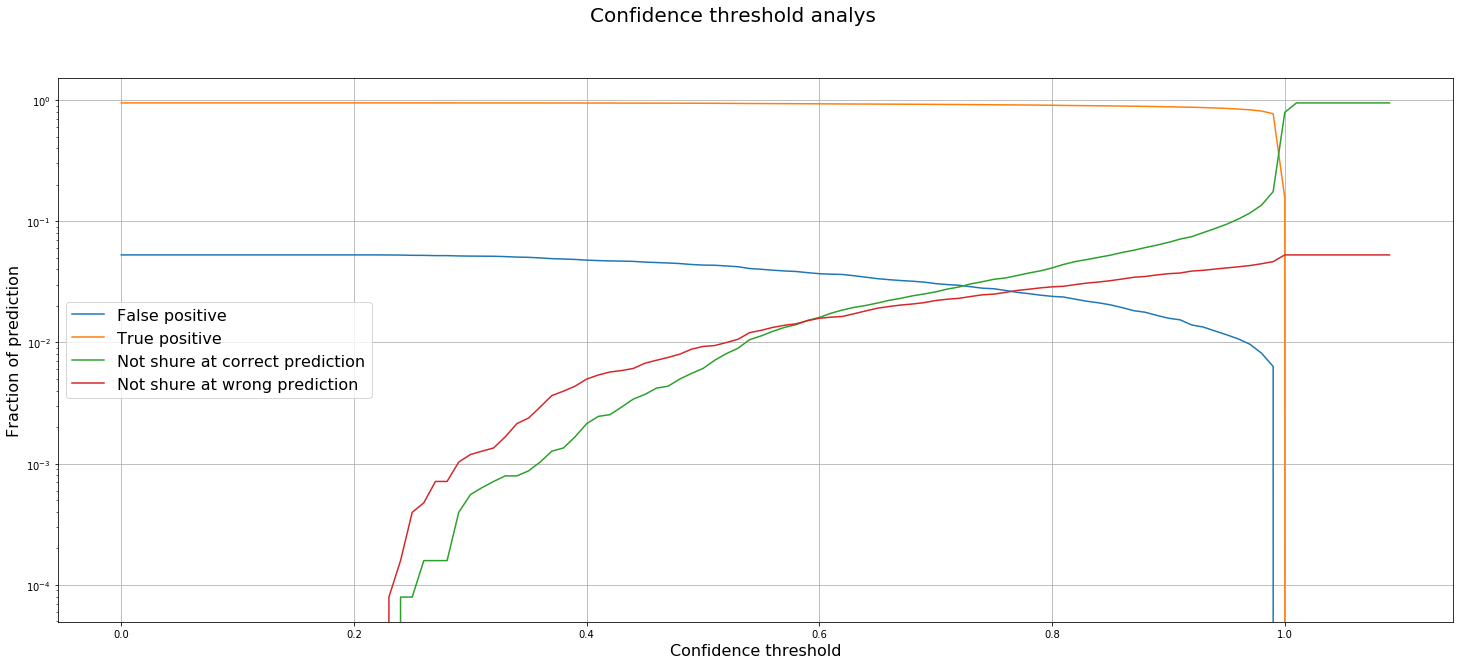

In [33]:
confidences = []

for confidence_threshold in tqdm.tqdm_notebook(np.arange(start=0, stop=1.1, step=0.01)):

    analys_df_confidence = analys_df.copy()
    new_predict = []
    for idx, row in analys_df_confidence.iterrows():
        new_predict.append('Not sure' if row['prediction_probas'] < confidence_threshold else 'Probably correct')

    analys_df_confidence['confidence_analys'] = new_predict

    false_positive = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Wrong') &
                                          (analys_df_confidence['confidence_analys'] == 'Probably correct')].shape[0]/analys_df_confidence.shape[0]
    
    true_positive = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Correct') &
                                          (analys_df_confidence['confidence_analys'] == 'Probably correct')].shape[0]/analys_df_confidence.shape[0]
    
    not_sure_at_wrong = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Wrong') &
                                          (analys_df_confidence['confidence_analys'] == 'Not sure')].shape[0]/analys_df_confidence.shape[0]
    
    not_sure_at_correct = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Correct') &
                                          (analys_df_confidence['confidence_analys'] == 'Not sure')].shape[0]/analys_df_confidence.shape[0]
    
    cf_level_result = {'fp': false_positive, 'tp': true_positive, 'ns_w': not_sure_at_wrong, 'ns_c': not_sure_at_correct, 'cf': confidence_threshold}
    confidences.append(cf_level_result)
    
confidences = pd.DataFrame(confidences)

fig, axes = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25,10))


sns.lineplot(x='cf', y='fp', data=confidences, ax=axes, label='False positive');
sns.lineplot(x='cf', y='tp', data=confidences, ax=axes, label='True positive');
sns.lineplot(x='cf', y='ns_c', data=confidences, ax=axes, label='Not shure at correct prediction');
sns.lineplot(x='cf', y='ns_w', data=confidences, ax=axes, label='Not shure at wrong prediction');

axes.set_yscale('log')
axes.set_xlabel('Confidence threshold', fontsize=16)
axes.set_ylabel('Fraction of prediction', fontsize=16);
axes.legend(loc='center left', prop={'size': 16})
fig.suptitle('Confidence threshold analys', fontsize=20);
plt.grid()

### Convolution neural network visualization

There are many method for consolutional neural network visualization in many papers. The simplest one - visualize image after consolutional layer. We stores all results after each convolutional layers

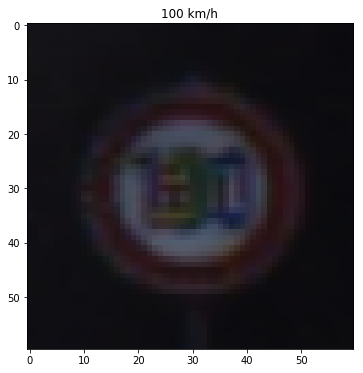

In [25]:
import matplotlib.gridspec as gridspec
res = sess.run([load_img, load_label, conv1, conv2, conv3, conv4, conv5, conv6],
               feed_dict={dp_rate: 0,
                          manual_load: False,
                          img_placeholder: np.zeros([12,60,60,3])})
img, label = res[0], res[1]
img_visible = (img*255).astype(np.uint8)[0, :, :, :]
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_visible)
ax.set_title(labels[label[0]])

filters = res[2:]
layer_names = ['Convolutional layer {}'.format(x+1) for x in range(len(filters))]

Convolutional layers have many filters. Visualizing all images is very epxencive and hard, but we will try. Results after convulition is not normalized, so we will normalized it manualy. Visualization looks like heatmap but it is not heatmap. It's just pretty visualization

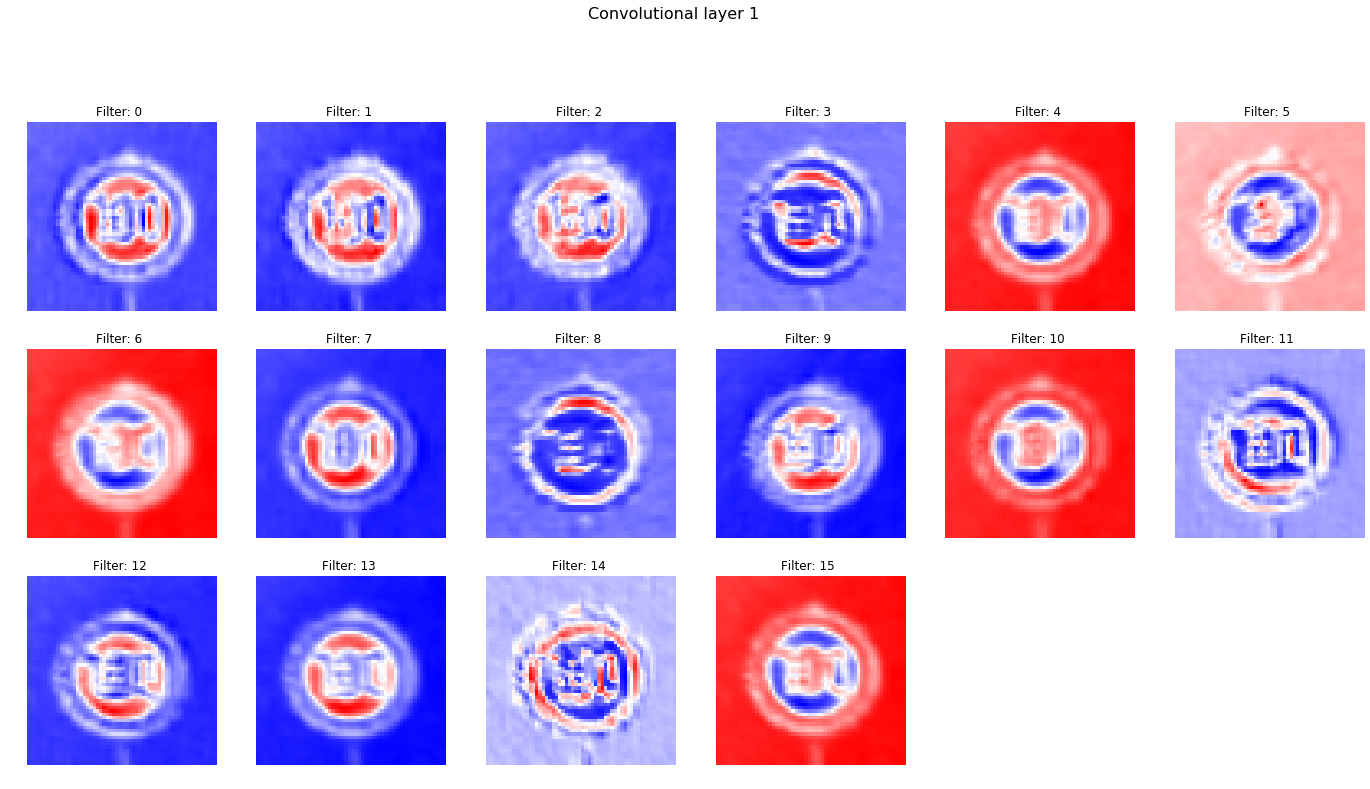

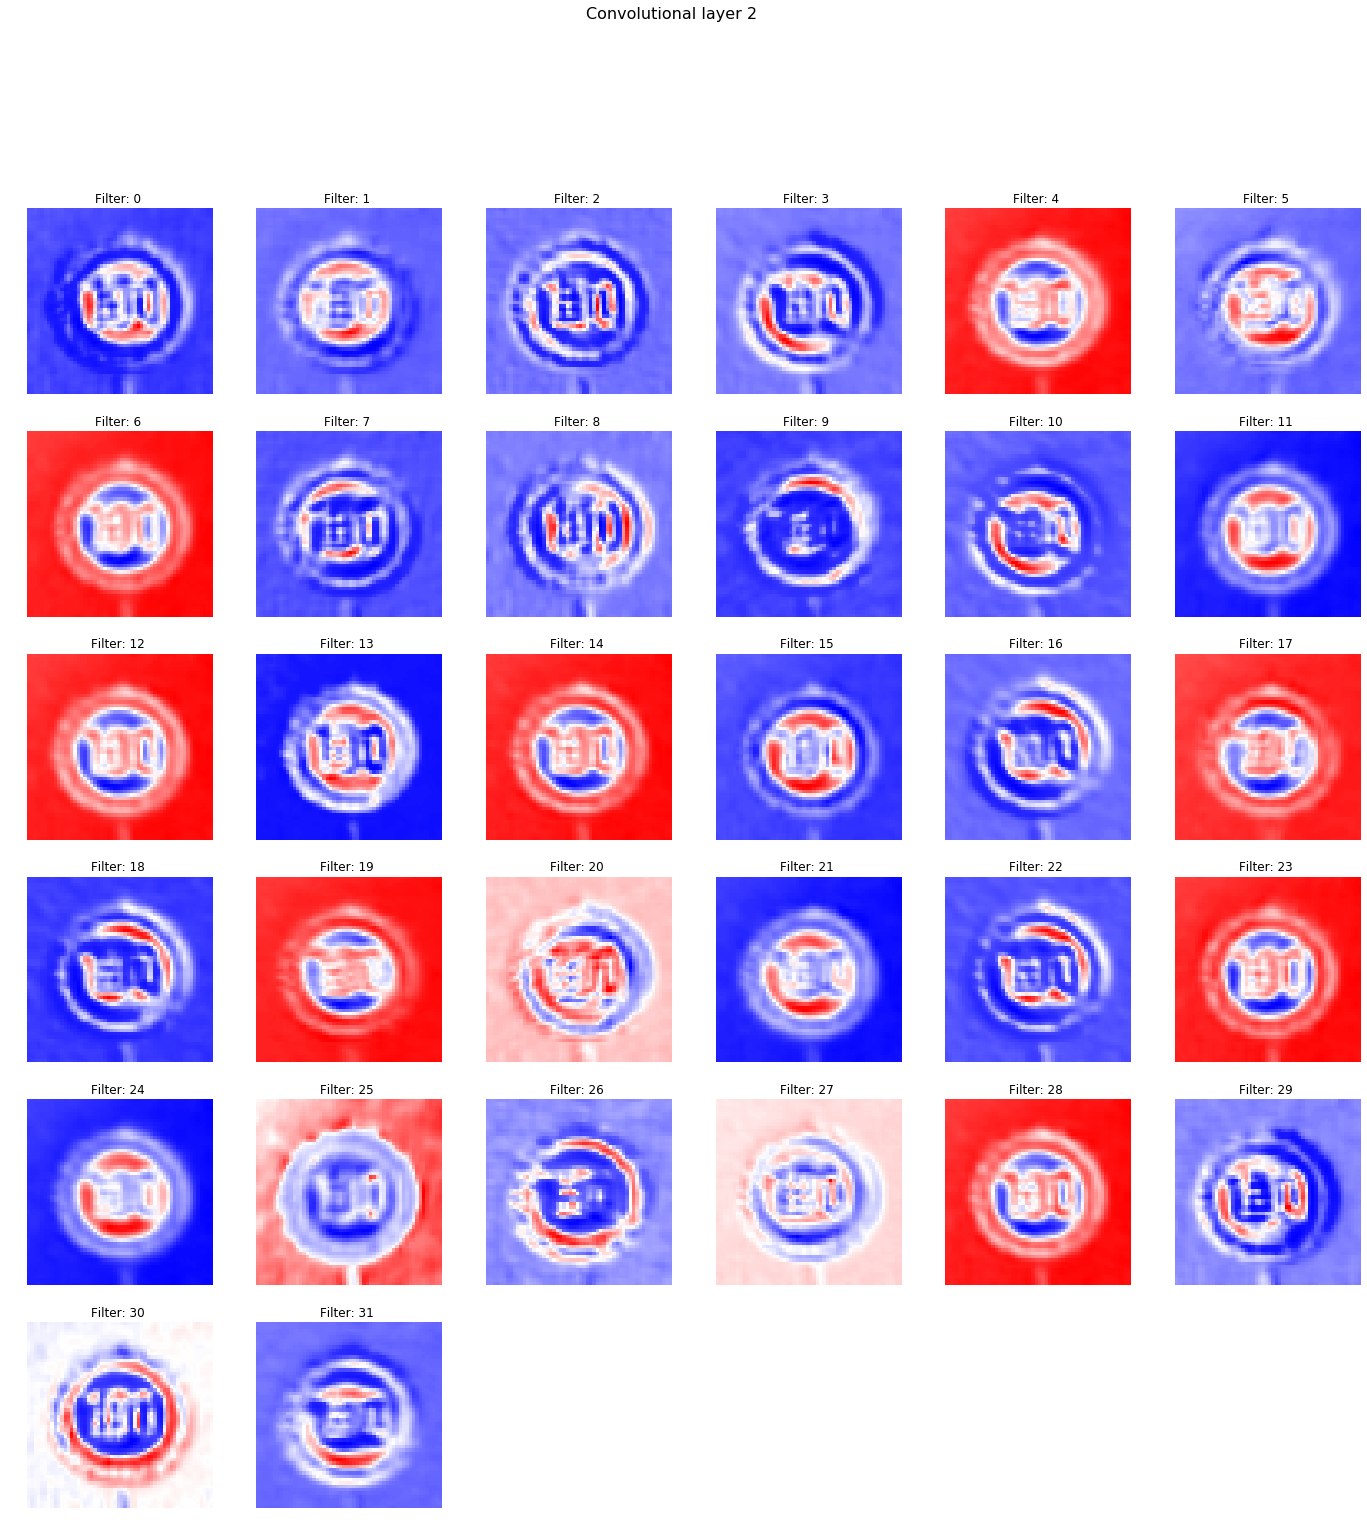

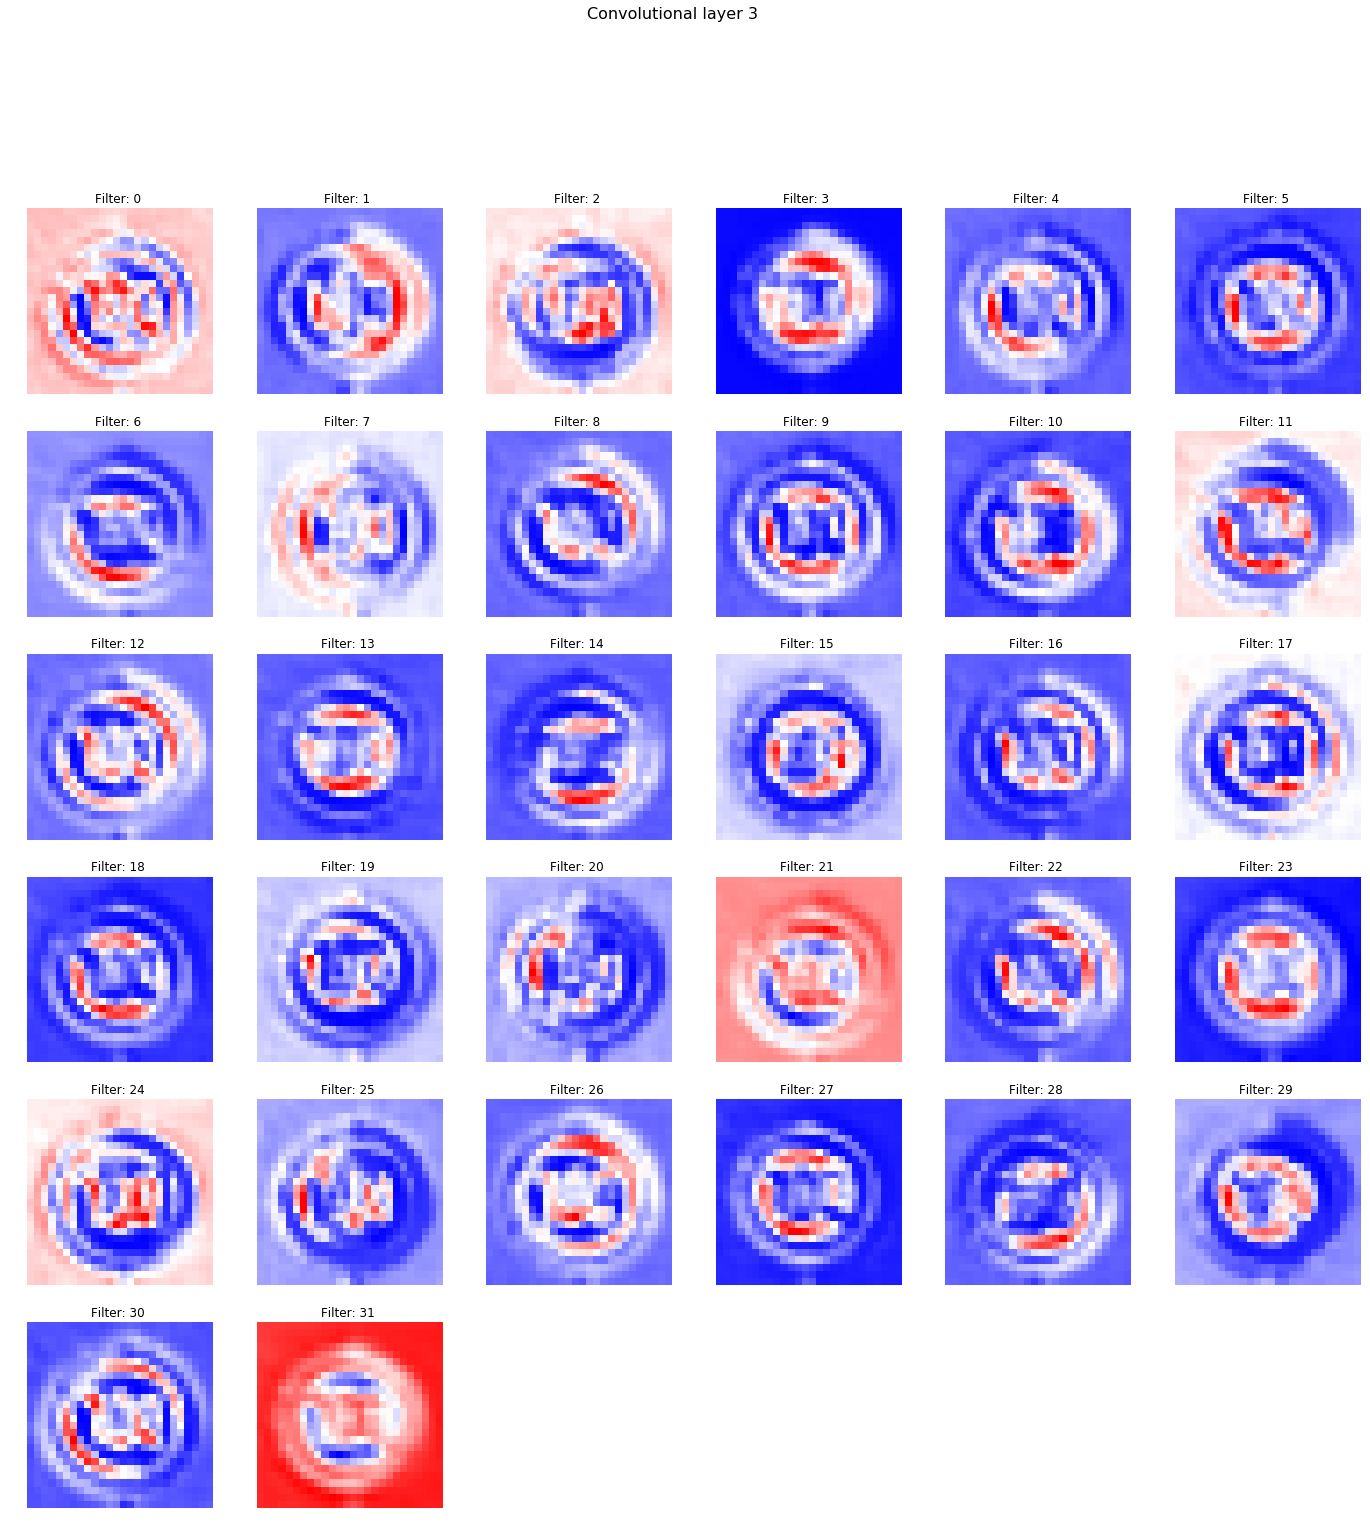

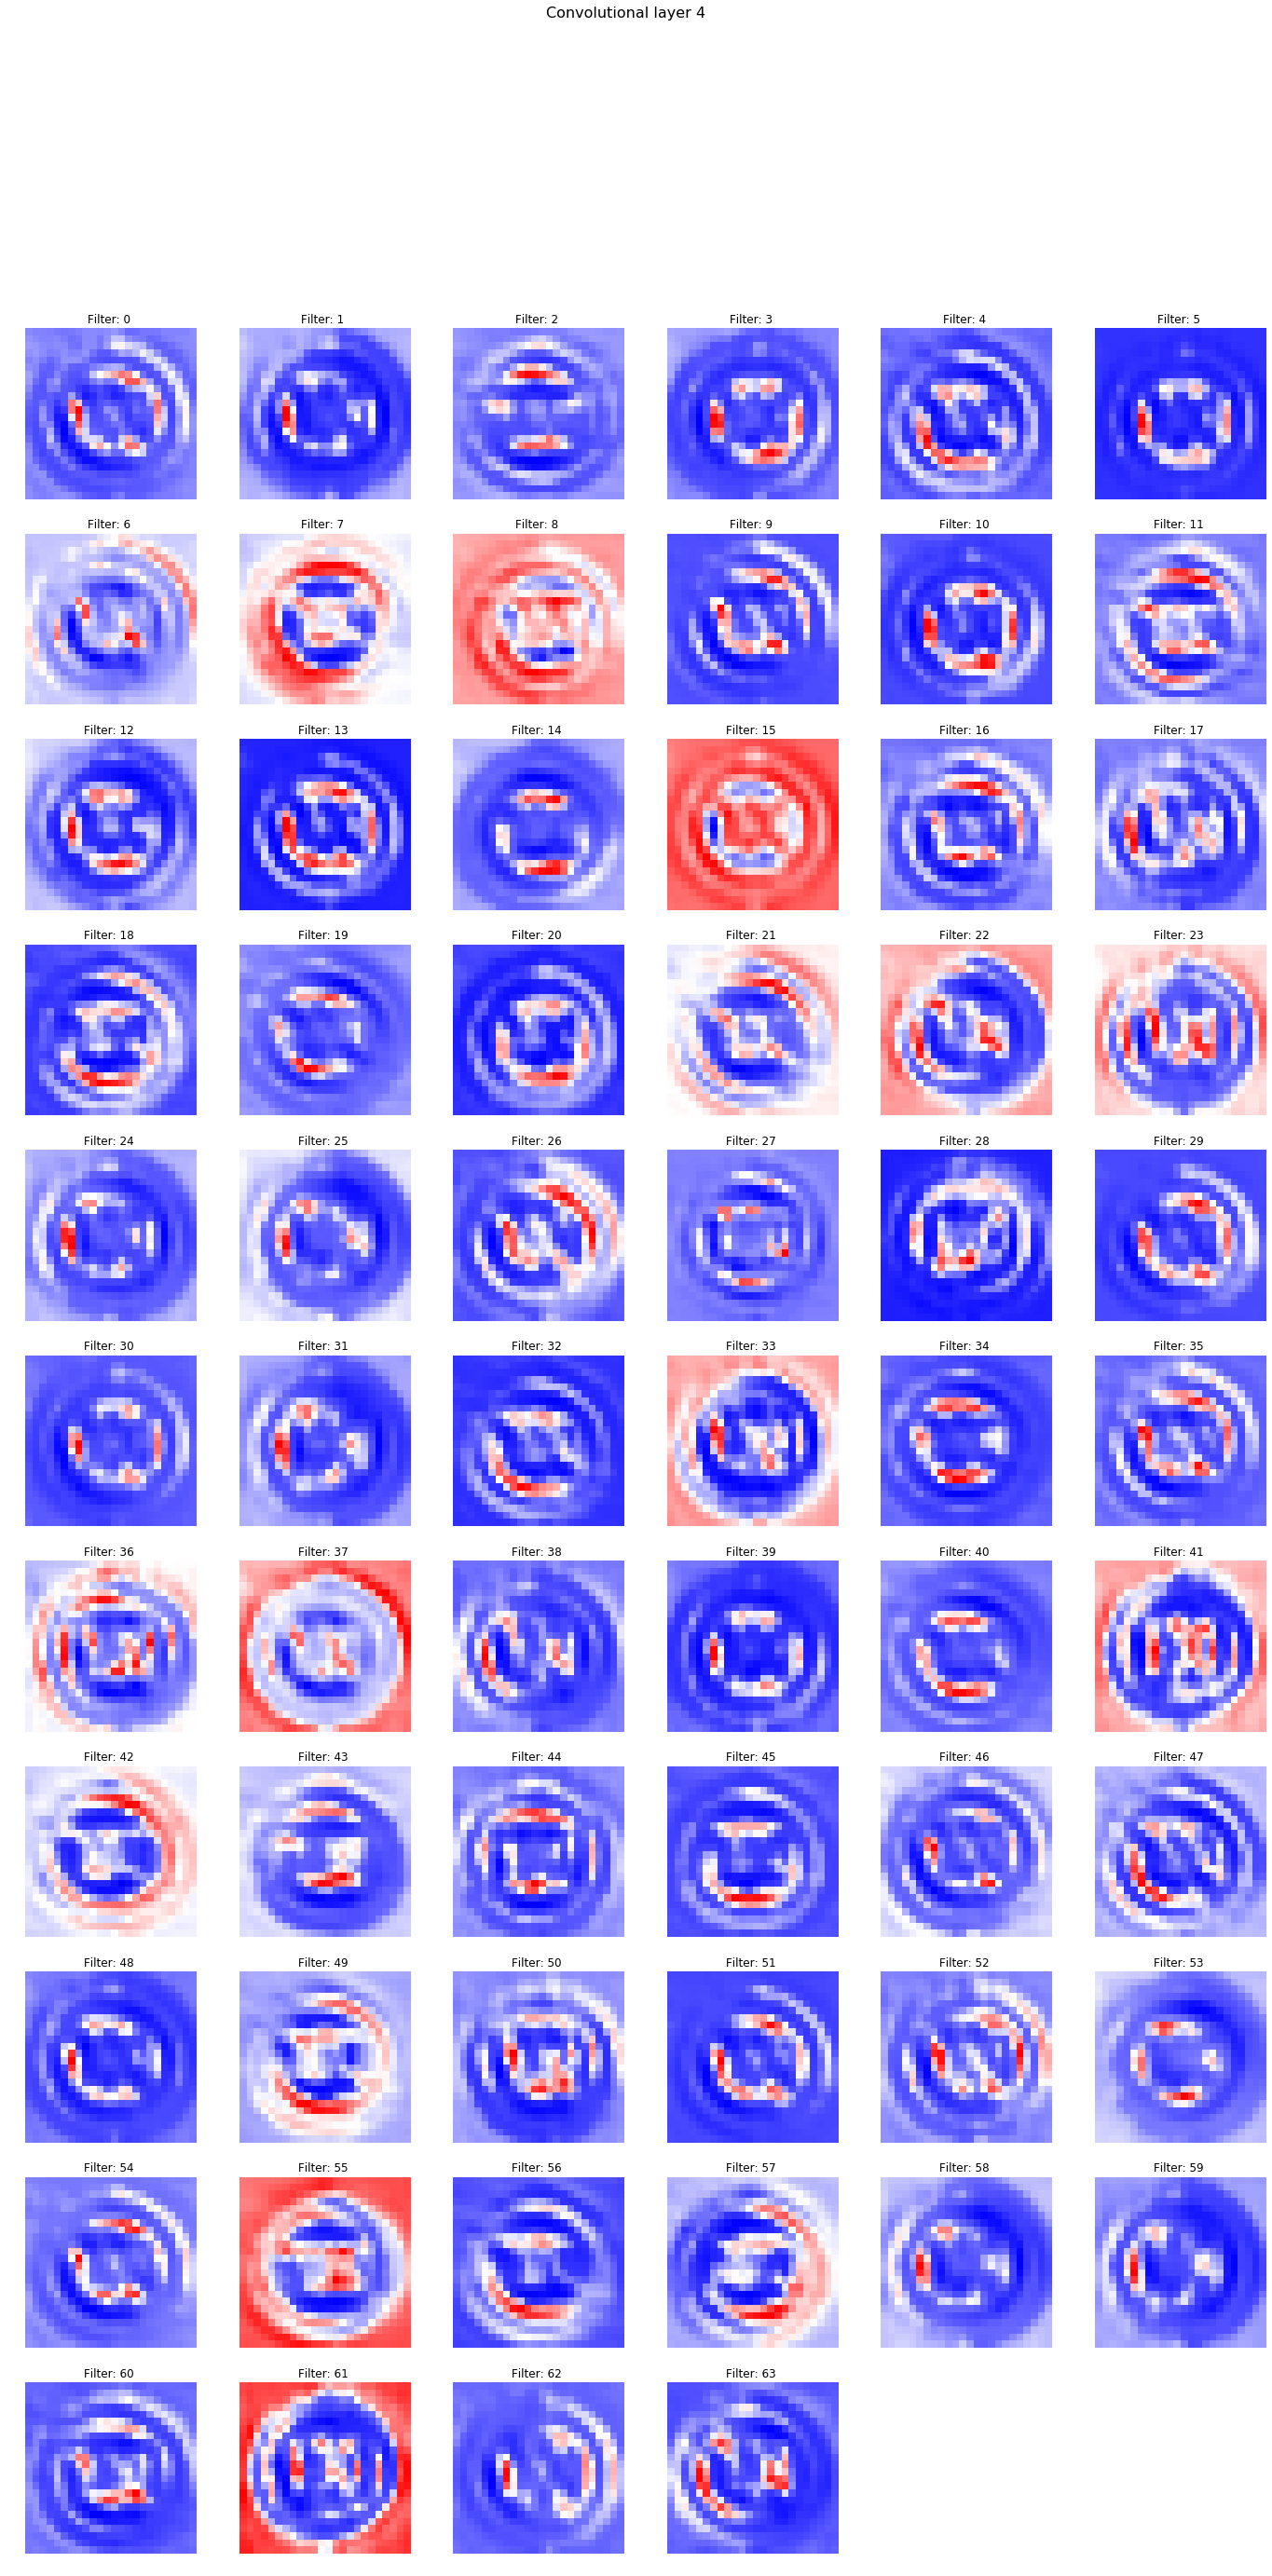

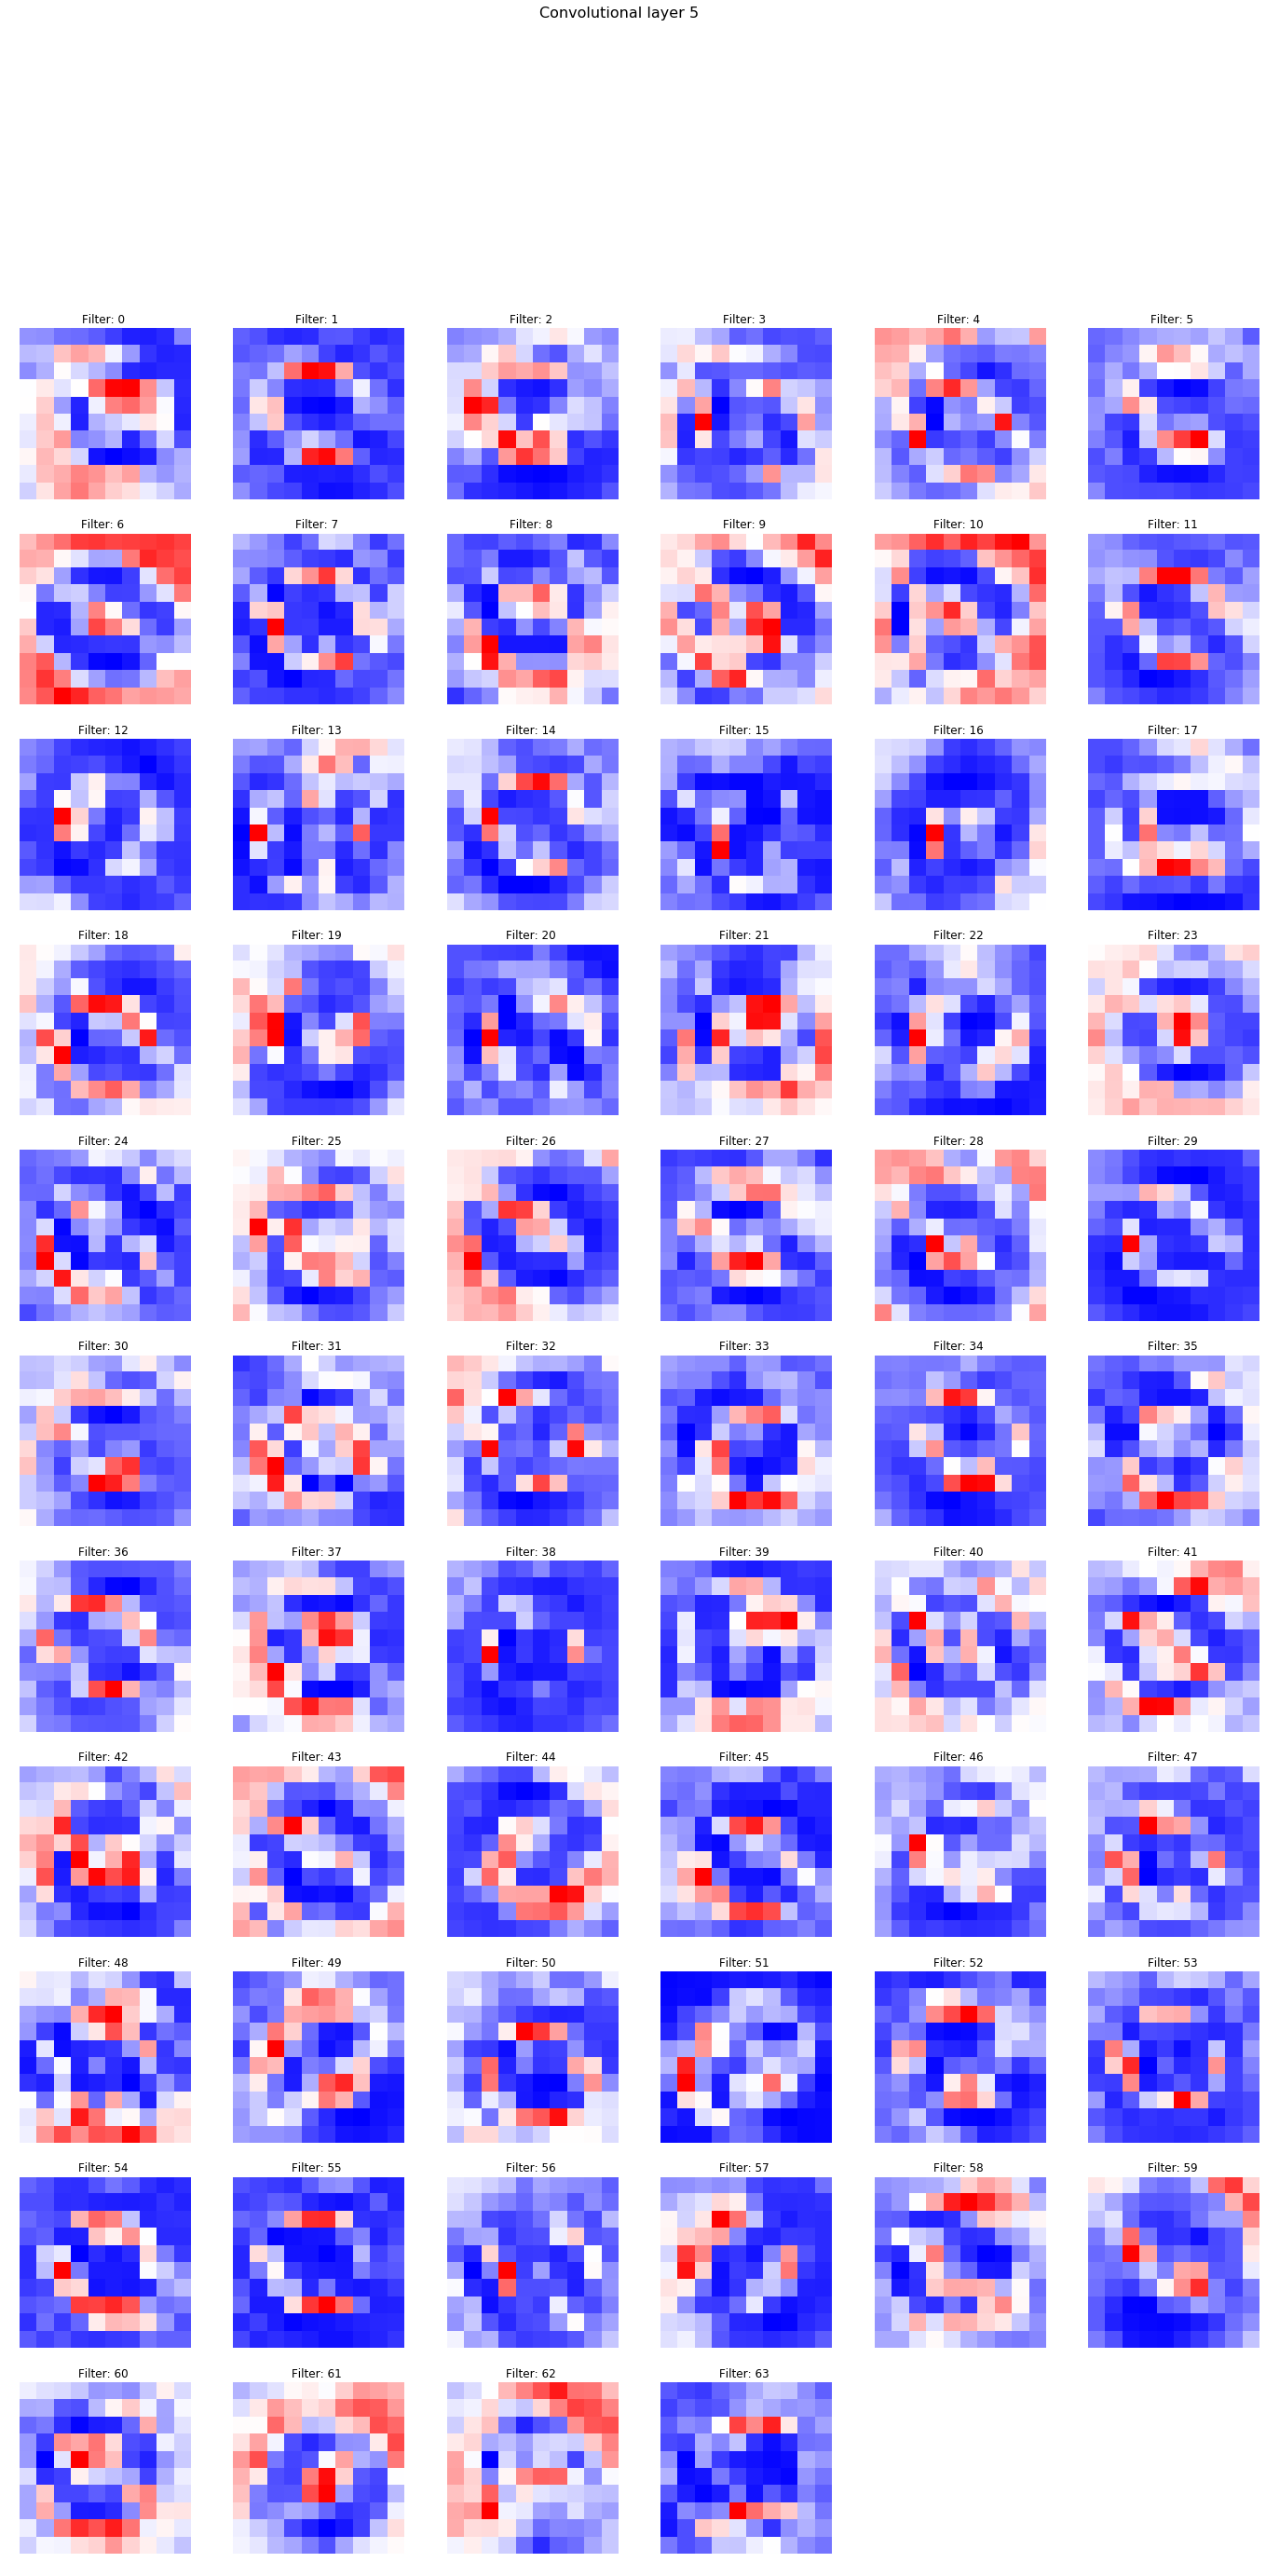

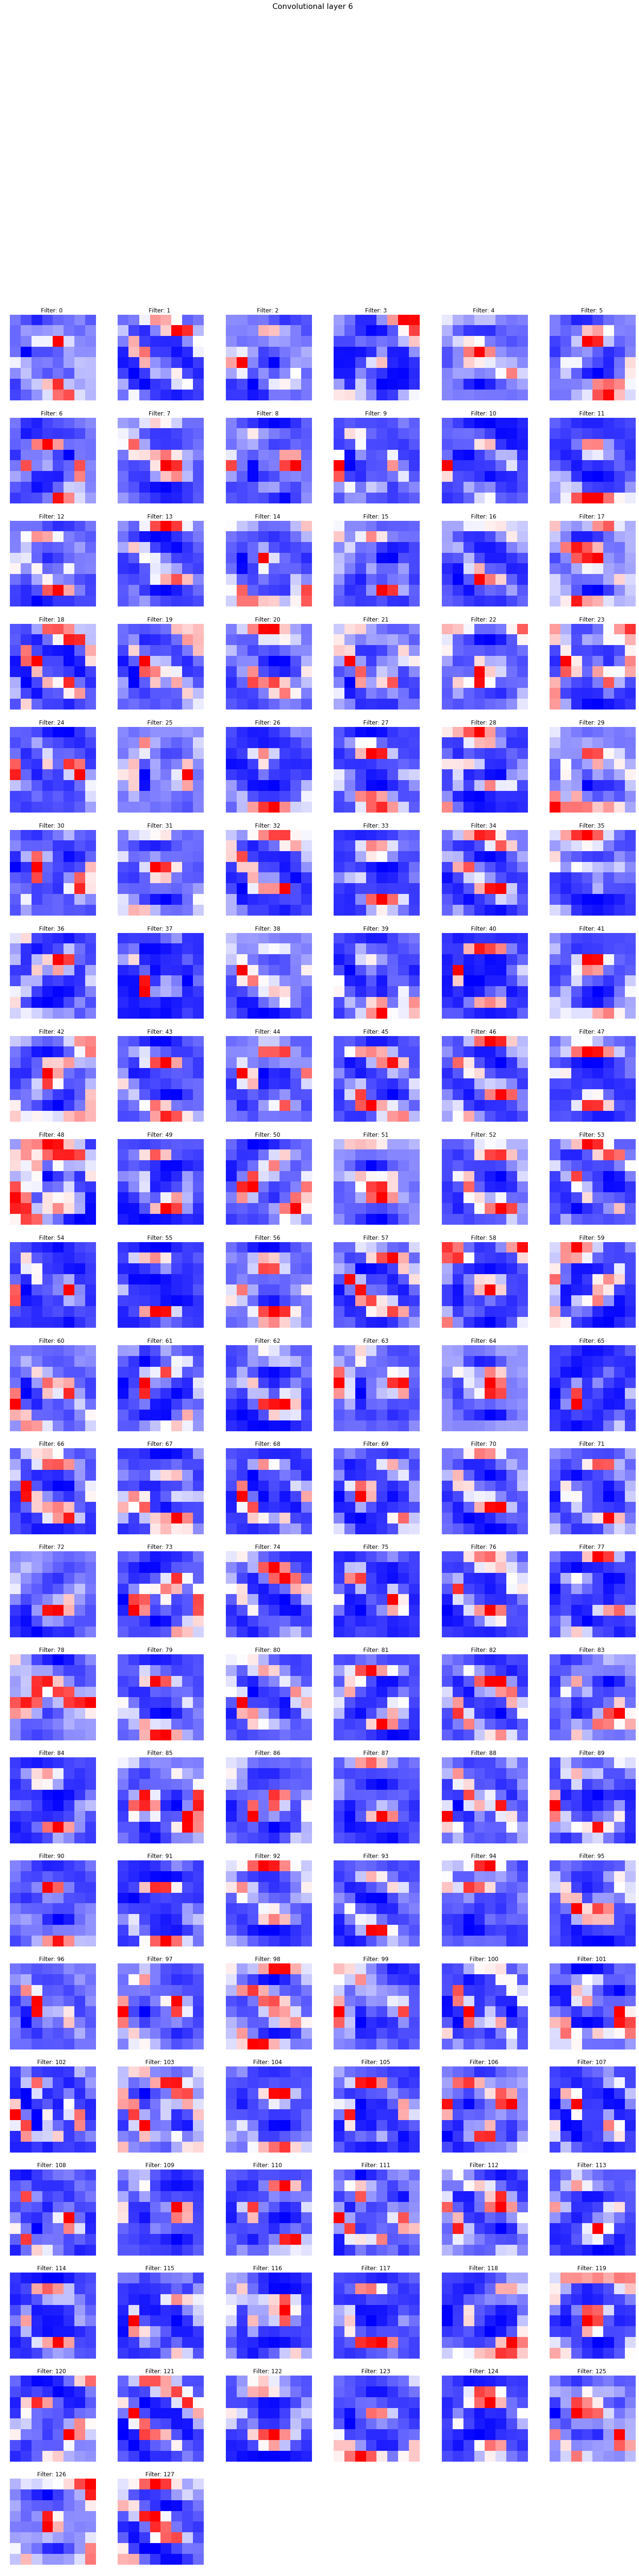

In [35]:
for filter_index in range(len(filters)):
    layers = filters[filter_index]
    filter_count = layers.shape[3]
    n_columns = 6
    n_rows = math.ceil(filter_count / n_columns) + 1
    fig = plt.figure(figsize=(24,n_rows*4));
    fig.suptitle(layer_names[filter_index], fontsize=16)
    for i in range(filter_count):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        plt.title('Filter: {0} '.format(str(i)))
        plt.imshow(layers[0,:,:,i], interpolation="nearest", cmap='bwr')
    plt.show()

### Grad-CAM

Another good way to understand what our model have learned - using Grad-CAM method. [Grad-CAM](https://arxiv.org/abs/1610.02391) - is Gradient-weighted Class Activation Map. We can see which parts of image are important for prediction (i.e. mostly cause prediction).

In [27]:
def grad_cam(sess, layer, predicted_class, nb_classes, img):
    conv_layer = layer
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    signal = tf.multiply(logits, one_hot)
    loss = tf.reduce_mean(signal)
    
    grads = tf.gradients(loss, conv_layer)[0]
    # Normalizing the gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict={dp_rate: 0, manual_load: True,
                                                                     img_placeholder: img})
    output = output[0]           
    grads_val = grads_val[0]     

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    # Taking a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224,224))

    # Converting grayscale to 3-D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3

Eveluate some samples and visualize Grad-CAM heatmaps

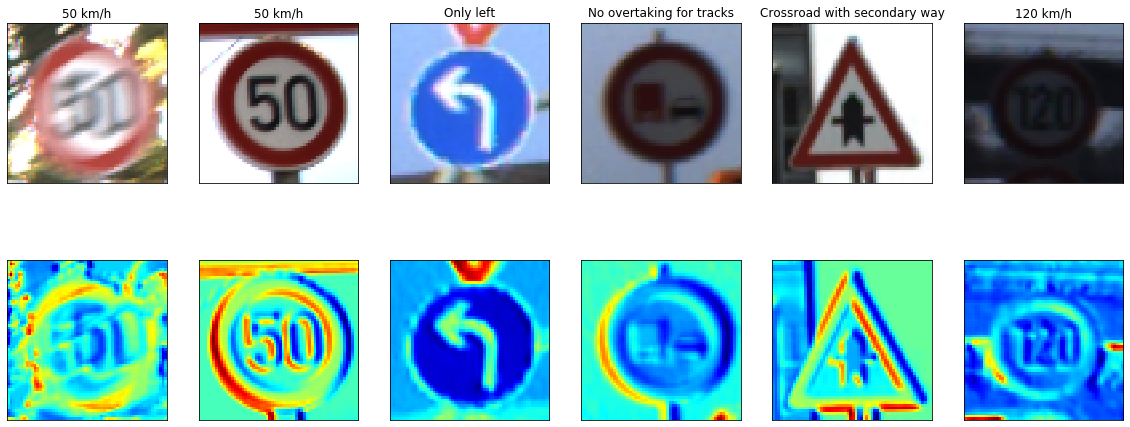

In [29]:
_img, _lb = sess.run([load_img, load_label])
grad_ipt = _img.copy()

samples = _img.shape[0]//2
fig, ax = plt.subplots(ncols=samples, nrows=2, figsize=(20, 8))
for i in range(samples):
    ax[0, i].imshow(_img[i, :, :, :])
    ax[0, i].get_xaxis().set_visible(False)
    ax[0, i].get_yaxis().set_visible(False)
    ax[0, i].set_title(labels[_lb[i]])
    
    image = _img[i, :, :, :]
    
    height = image.shape[0]
    width = image.shape[1]

    grad_ipt[0, :, :] = _img[i, :, :]
    heat_map = grad_cam(sess, conv1, _lb[i], 43, grad_ipt)
    # resize heat map
    heat_map_resized = cv2.resize(heat_map, (height, width))

    # normalize heat map
    max_value = np.max(heat_map_resized)
    min_value = np.min(heat_map_resized)
    normalized_heat_map = (heat_map_resized - min_value) / (max_value - min_value)
    normalized_heat_map = cv2.applyColorMap((normalized_heat_map*255).astype(np.uint8), cv2.COLORMAP_JET)
    
    ax[1, i].imshow(normalized_heat_map)
    ax[1, i].get_xaxis().set_visible(False)
    ax[1, i].get_yaxis().set_visible(False)